# Notes 2 - Predictors of recorded DS live births

Next:

- Review data to see if we can go back further - check race
- Hyperparameter tuning
- Consider bagging vs GOSS


## Preparation


In [1]:
import duckdb, joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    brier_score_loss,
    log_loss,
    precision_recall_fscore_support,
    roc_curve,
)
from sklearn.model_selection import train_test_split

from variables import Variables as vars
import repl_utils, stats_utils

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = repl_utils.RANDOM_SEED
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)
START_TIME = datetime.now()
OUTPUT_DIR = f"output/0002-predictors/{START_TIME:%Y%m%d-%H%M%S}"

SAVE_PLOTS = True

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


-------------------- Environment Information --------------------
date: 2025-12-21T18:29:20.718502
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
cores: 32
physical_cores: 24
ram: 127 GB
ram_available: 100 GB
cuda: True
cuda_device_count: 1
cuda_device_0: NVIDIA GeForce RTX 4070 Ti SUPER
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
pytorch: 2.9.1
pymc: 5.26.1
pytensor: 2.35.1
arviz: 0.23.0

--------------------
Output directory: output/0002-predictors/20251221-182920
--------------------



### Options


In [2]:
START_YEAR = 2005
# LightGBM threads
NUM_THREADS = N_CORES
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.5
VALIDATION_SPLIT = 0.25
CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 50
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = True
#
OPTIMIZE_TRIALS = 50

### Load data


In [3]:
con = duckdb.connect("./data/us_births.db", read_only=True)

df = con.execute(
    f"""
    SELECT
        -- (training label) indicated if C or P, not indicated if N, U and missing excluded from training
        CASE
            WHEN COALESCE (ca_down, ca_downs) = 'C' THEN 1::UTINYINT
            WHEN COALESCE (ca_down, ca_downs) = 'P' THEN 1::UTINYINT
            WHEN COALESCE (ca_down, ca_downs) = 'N' THEN 0::UTINYINT
            WHEN uca_downs = 1 THEN 1::UTINYINT
            WHEN uca_downs = 2 THEN 0::UTINYINT
            ELSE NULL
        END AS ca_down_c_p_n,        
        -- ==================== date of birth ====================
        year,
        -- ==================== birth location ====================
        -- birth place (1: hospital, 2: not hospital, 3: unknown/not stated)
        bfacil3,
        -- ==================== characteristics of baby ====================
        -- sex of baby
        CASE
            WHEN sex = 'M' THEN 1::UTINYINT
            WHEN sex = 'F' THEN 0::UTINYINT
            ELSE NULL
        END AS sex,
        -- birth weight (grams)
        CASE
            WHEN dbwt >= 227 AND dbwt <= 8165 THEN dbwt
            -- we ignore "Not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS dbwt,
        -- ==================== characteristics of pregnancy ====================
        -- plurality (1: single... 4 quadpruplet or higher)
        dplural,
        -- month prenatal care began (1 to 10, 0: no prenatal care)
        CASE
            WHEN precare >= 0 AND precare <= 10 THEN precare
            WHEN precare = 99 THEN precare
            ELSE NULL
        END AS precare,
        -- combined gestation estimate
        CASE
            WHEN gestrec10 >= 1 AND gestrec10 <= 10 THEN gestrec10
            WHEN gestrec10 = 99 THEN gestrec10
            ELSE NULL
        END AS gestrec10,
        -- pre-pregnancy weight recode (in pounds)
        CASE
            WHEN pwgt_r >= 75 AND pwgt_r <= 375 THEN pwgt_r
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS pwgt_r,
        -- weight gain in pounds (98 = 98+)
        CASE
            WHEN wtgain >= 0 AND wtgain <= 98 THEN wtgain
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS wtgain,
        -- maternal body mass index
        CASE
            WHEN bmi >= 13.0 AND bmi < 69.9 THEN bmi
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END
        AS bmi,
        -- ==================== pregnancy risk factors ====================
        -- pre-pregnancy diabetes
        CASE
            WHEN rf_pdiab = 'Y' THEN 1::UTINYINT
            WHEN rf_pdiab = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_pdiab,
        -- gestational diabetes
        CASE
            WHEN rf_gdiab = 'Y' THEN 1::UTINYINT
            WHEN rf_gdiab = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_gdiab,
        -- pre-pregnancy hypertension
        CASE
            WHEN rf_phype = 'Y' THEN 1::UTINYINT
            WHEN rf_phype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_phype,
        -- gestational hypertension
        CASE
            WHEN rf_ghype = 'Y' THEN 1::UTINYINT
            WHEN rf_ghype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ghype,
        -- hypertension eclampsia
        CASE
            WHEN rf_ehype = 'Y' THEN 1::UTINYINT
            WHEN rf_ehype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ehype,
        -- previous preterm birth
        CASE
            WHEN rf_ppterm = 'Y' THEN 1::UTINYINT
            WHEN rf_ppterm = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ppterm,
        -- infertility treatment used
        CASE
            WHEN rf_inftr = 'Y' THEN 1::UTINYINT
            WHEN rf_inftr = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_inftr,
        -- fertility enhancing drugs
        CASE
            WHEN rf_fedrg = 'Y' THEN 1::UTINYINT
            WHEN rf_fedrg = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_fedrg,
        -- asst. reproductive technology
        CASE
            WHEN rf_artec = 'Y' THEN 1::UTINYINT
            WHEN rf_artec = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_artec,
        -- no risk factors reported
        CASE
            WHEN no_risks <= 1 THEN no_risks
            ELSE NULL
        END AS no_risks,
        -- ==================== labor and delivery ====================
        -- induction of labor
        CASE
            WHEN ld_indl = 'Y' THEN 1::UTINYINT
            WHEN ld_indl = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ld_indl,
        -- augmentation of labor
        CASE
            WHEN ld_augm = 'Y' THEN 1::UTINYINT
            WHEN ld_augm = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ld_augm,
        -- fetal presentation at delivery
        CASE
            WHEN me_pres >= 1 AND me_pres <= 3 THEN me_pres
            WHEN me_pres = 9 THEN me_pres
            ELSE NULL
        END AS me_pres,
        -- delivery method recode
        CASE
            WHEN dmeth_rec >= 1 AND dmeth_rec <= 2 THEN dmeth_rec
            WHEN dmeth_rec = 9 THEN dmeth_rec
            ELSE NULL
        END AS dmeth_rec,
        -- ==================== newborn health ====================
        -- five minute apgar score
        CASE
            WHEN apgar5 >= 10 AND apgar5 <= 10 THEN apgar5
            WHEN apgar5 = 99 THEN apgar5
            ELSE NULL
        END AS apgar5,
        -- ten minute apgar score
        CASE
            WHEN apgar10 >= 10 AND apgar10 <= 10 THEN apgar10
            WHEN apgar10 = 99 THEN apgar10
            ELSE NULL
        END AS apgar10,
        -- assisted ventilation (immediately)
        CASE
            WHEN ab_aven1 = 'Y' THEN 1::UTINYINT
            WHEN ab_aven1 = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_aven1,
        -- assisted ventilation > 6 hrs
        CASE
            WHEN ab_aven6 = 'Y' THEN 1::UTINYINT
            WHEN ab_aven6 = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_aven6,
        -- admitted to nicu
        CASE
            WHEN ab_nicu = 'Y' THEN 1::UTINYINT
            WHEN ab_nicu = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_nicu,
        -- surfactant
        CASE
            WHEN ab_surf = 'Y' THEN 1::UTINYINT
            WHEN ab_surf = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_surf,
        -- antibiotics for newborn
        CASE
            WHEN ab_anti = 'Y' THEN 1::UTINYINT
            WHEN ab_anti = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_anti,
        -- seizures
        CASE
            WHEN ab_seiz = 'Y' THEN 1::UTINYINT
            WHEN ab_seiz = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_seiz,
        -- no_abnorm
        CASE
            WHEN no_abnorm >= 0 AND no_abnorm <= 1 THEN no_abnorm
            WHEN no_abnorm = 9 THEN no_abnorm
            ELSE NULL
        END AS no_abnorm,
        -- ==================== identified disorders ====================
        -- congenital disorder
        CASE
            WHEN ca_disor = 'C' THEN 1::UTINYINT
            WHEN ca_disor = 'P' THEN 2::UTINYINT
            WHEN ca_disor = 'N' THEN 0::UTINYINT
            ELSE NULL
        END
        AS ca_disor,
        -- anencephaly
        CASE
            WHEN ca_anen = 'Y' THEN 1::UTINYINT
            WHEN ca_anen = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_anen,
        -- meningomyelocele / spina bifida
        CASE
            WHEN ca_mnsb = 'Y' THEN 1::UTINYINT
            WHEN ca_mnsb = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_mnsb,
        -- congenital heart defect
        CASE
            WHEN ca_cchd = 'Y' THEN 1::UTINYINT
            WHEN ca_cchd = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cchd,
        -- ca_cdh
        CASE
            WHEN ca_cdh = 'Y' THEN 1::UTINYINT
            WHEN ca_cdh = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cdh,
        -- omphalocele
        CASE
            WHEN ca_omph = 'Y' THEN 1::UTINYINT
            WHEN ca_omph = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_omph,
        -- gastroschisis
        CASE
            WHEN ca_gast = 'Y' THEN 1::UTINYINT
            WHEN ca_gast = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_gast,
        -- limb reduction defect
        CASE
            WHEN ca_limb = 'Y' THEN 1::UTINYINT
            WHEN ca_limb = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_limb,
        -- cleft lip w/ or w/o cleft palate
        CASE
            WHEN ca_cleft = 'Y' THEN 1::UTINYINT
            WHEN ca_cleft = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cleft,
        -- cleft palate alone
        CASE
            WHEN ca_clpal = 'Y' THEN 1::UTINYINT
            WHEN ca_clpal = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_clpal,
        -- Hypospadias
        CASE
            WHEN ca_hypo = 'Y' THEN 1::UTINYINT
            WHEN ca_hypo = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_hypo,
        -- suspected chromosomal disorder
        CASE
            WHEN ca_disor = 'C' THEN 1::UTINYINT
            WHEN ca_disor = 'P' THEN 2::UTINYINT
            WHEN ca_disor = 'N' THEN 0::UTINYINT
            WHEN ca_disor = 'U' THEN 9::UTINYINT
            ELSE NULL
        END AS ca_disor,
        -- no_congen
        CASE
            WHEN no_congen >= 0 AND no_congen <= 1 THEN no_congen
            WHEN no_congen = 9 THEN no_congen
            ELSE NULL
        END AS no_congen,
        -- ==================== maternal characteristics ====================
        -- maternal age in years
        mage_c,
        -- maternal education
        CASE
            WHEN meduc >= 0 AND meduc < 10 THEN meduc
            ELSE NULL
        END AS meduc,
        -- maternal race
        CASE
            WHEN  mracehisp >= 1 AND mracehisp <= 8 THEN mracehisp
            ELSE NULL
        END AS mracehisp,
        -- ==================== paternal characteristics ====================
        -- father's combined age in years
        CASE
            WHEN fagecomb >= 9 AND fagecomb < 99 THEN fagecomb
            ELSE NULL
        END AS fagecomb,
        -- paternal education
        CASE
            WHEN  feduc < 9 THEN feduc
            ELSE NULL
        END AS feduc,
        -- paternal race
        CASE
            WHEN  fracehisp >= 1 AND fracehisp <= 10 THEN fracehisp
            ELSE NULL
        END AS fracehisp,
        -- ==================== socio-economic indicators ====================
        -- payment source recode
        CASE
            WHEN  pay_rec < 5 THEN pay_rec
            ELSE NULL
        END AS pay_rec,
        -- supplemental nutrition program for women, infants, and children
        CASE
            WHEN wic = 'Y' THEN 1::UTINYINT
            WHEN wic = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS wic
    FROM
        us_births
    WHERE year >= {START_YEAR} AND ca_down_c_p_n IS NOT NULL
    ORDER BY
        year, dob_mm, dob_wk
    """
).df()

con.close()

df.describe().T

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,count,mean,std,min,25%,50%,75%,max
ca_down_c_p_n,78161818.0,0.000508,0.022542,0.0,0.0,0.0,0.0,1.0
year,78161818.0,2014.217173,5.753869,2005.0,2009.0,2014.0,2019.0,2024.0
bfacil3,78161818.0,1.015354,0.123327,1.0,1.0,1.0,1.0,3.0
sex,78161818.0,0.511585,0.499866,0.0,0.0,1.0,1.0,1.0
dbwt,78100022.0,3261.827446,589.739979,227.0,2963.0,3300.0,3629.0,8165.0
dplural,78161098.0,1.034702,0.189742,1.0,1.0,1.0,1.0,4.0
precare,63370803.0,2.968378,1.54624,0.0,2.0,3.0,3.0,10.0
gestrec10,78161818.0,6.867912,2.561594,1.0,6.0,7.0,8.0,99.0
pwgt_r,56063606.0,158.142198,41.523378,75.0,130.0,150.0,180.0,375.0
wtgain,73879773.0,30.046515,14.979685,0.0,20.0,30.0,39.0,98.0


In [ ]:
def ap_scorer(estimator, X, y):
    """
    Average precision scorer for sklearn's cross-validation and hyperparameter tuning utilities.
    """
    proba = estimator.predict_proba(X)[:, 1]
    return average_precision_score(y, proba)


class LGBMEstimator:
    """
    A wrapper for a LightGBM booster to provide sklearn-like interface.
    This is needed because we train the LightGBM model using its native API,
    but we want to use it with sklearn utilities like permutation importance.
    """

    def __init__(self, booster, threshold=0.5):
        self.booster = booster
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def _predict_p1(self, X):
        # Use the early-stopped model size: if we omit num_iteration=best_iteration, then permutation
        # importance might be computed using the full num_boost_round trees (or whatever the booster
        # currently holds),
        num_iter = getattr(self.booster, "best_iteration", None)
        if num_iter is None or num_iter == 0:
            return self.booster.predict(X)
        return self.booster.predict(X, num_iteration=num_iter)

    # ap_scorer calls predict_proba(),
    def predict_proba(self, X):
        p1 = self._predict_p1(X)
        p0 = 1.0 - p1
        return np.column_stack([p0, p1])

    def predict(self, X):
        p1 = self._predict_p1(X)
        return (p1 >= self.threshold).astype(int)

In [ ]:
def group_permutation_importance(
    estimator,
    X: pd.DataFrame,
    y: pd.Series,
    groups: dict[str, list[str]],
    scorer=average_precision_score,
    n_repeats: int = 5,
    random_state: int = 0,
    use_predict_proba: bool = True,
):
    """
    Compute group permutation importance.

    Parameters
    ----------
    estimator : object
        Must implement predict_proba(X) -> (n,2) or predict(X) -> (n,).
        Your LGBMWrapper works.
    X : DataFrame
        Evaluation data.
    y : Series/array
        Labels (0/1).
    groups : dict
        Mapping group_name -> list of column names to permute together.
    scorer : callable
        For AP, pass average_precision_score.
    n_repeats : int
        Permutation repeats per group.
    random_state : int
        Seed.
    use_predict_proba : bool
        If True, scorer uses predict_proba[:,1], else uses predict.

    Returns
    -------
    DataFrame with mean/std importance per group (higher = more important).
    Importance is measured as decrease in score when permuted: (baseline - permuted).
    """
    rng = np.random.default_rng(random_state)

    # baseline score
    if use_predict_proba:
        p = estimator.predict_proba(X)[:, 1]
        baseline = scorer(y, p)
    else:
        pred = estimator.predict(X)
        baseline = scorer(y, pred)

    results = []
    X_work = X.copy()

    for gname, cols in groups.items():
        cols = [c for c in cols if c in X.columns]
        if len(cols) == 0:
            continue

        drops = []
        for _ in range(n_repeats):
            # Permute rows consistently across the whole group
            perm = rng.permutation(len(X_work))

            # Apply permutation to each column in the group
            X_perm = X_work.copy()
            for c in cols:
                X_perm[c] = X_work[c].to_numpy()[perm]

            if use_predict_proba:
                p_perm = estimator.predict_proba(X_perm)[:, 1]
                score_perm = scorer(y, p_perm)
            else:
                pred_perm = estimator.predict(X_perm)
                score_perm = scorer(y, pred_perm)

            drops.append(baseline - score_perm)

        results.append(
            {
                "group": gname,
                "n_features": len(cols),
                "features": cols,
                "baseline_score": baseline,
                "importance_mean": float(np.mean(drops)),
                "importance_std": (
                    float(np.std(drops, ddof=1)) if n_repeats > 1 else 0.0
                ),
            }
        )

    out = (
        pd.DataFrame(results)
        .sort_values("importance_mean", ascending=False)
        .reset_index(drop=True)
    )
    return out

In [5]:
def score_metrics(y_true, p_valid):
    """
    Compute validation metrics: AUC, AP, log loss, ROC curve.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels.
    p_valid : array-like of shape (n_samples,)
        Predicted probabilities or scores.

    Returns
    -------
    p_valid_auc : float
        Area Under the ROC Curve.
    p_valid_ap : float
        Average Precision score.
    p_valid_ll : float
        Log loss.
    p_valid_fpr : array-like of shape (n_thresholds,)
        False Positive Rates for ROC curve.
    p_valid_tpr : array-like of shape (n_thresholds,)
        True Positive Rates for ROC curve.
    p_valid_thresholds : array-like of shape (n_thresholds,)
        Thresholds used to compute ROC curve.
    """
    p_valid_auc = roc_auc_score(y_true, p_valid)
    p_valid_ap = average_precision_score(y_true, p_valid)
    p_valid_ll = log_loss(y_true, p_valid, labels=[0, 1])
    p_valid_fpr, p_valid_tpr, p_valid_thresholds = roc_curve(y_true, p_valid)
    return (
        p_valid_auc,
        p_valid_ap,
        p_valid_ll,
        p_valid_fpr,
        p_valid_tpr,
        p_valid_thresholds,
    )


def precision_recall_at_k(y_true, p_valid, K: int = 10000):
    """
    Compute precision and recall at top K predictions.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels.
    p_valid : array-like of shape (n_samples,)
        Predicted probabilities or scores.
    K : int
        Number of top predictions to consider.

    Returns
    -------
    precision_at_k : float
        Precision at top K predictions.
    recall_at_k : float
        Recall at top K predictions.
    """
    order = np.argsort(-p_valid)
    y_sorted = y_true.to_numpy()[order]
    precision_at_k = y_sorted[:K].mean()
    recall_at_k = y_sorted[:K].sum() / y_true.sum()
    return precision_at_k, recall_at_k


def precision_recall_at_threshold(y_true, p_valid, thr: float = 0.01):
    """
    Compute precision and recall at a given threshold.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels.
    p_valid : array-like of shape (n_samples,)
        Predicted probabilities or scores.
    thr : float
        Threshold for converting predicted probabilities to binary predictions.

    Returns
    -------
    prec : float
        Precision at the given threshold.
    rec : float
        Recall at the given threshold.
    f1 : float
        F1-score at the given threshold.
    """
    y_hat = (p_valid >= thr).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary")
    return prec, rec, f1


def get_metrics(y_true, p_valid, K: int = 10000, thr: float = 0.01):
    """
    Build a DataFrame of validation metrics.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True binary labels.
    p_valid : array-like of shape (n_samples,)
        Predicted probabilities or scores.
    K : int
        Number of top predictions to consider for precision/recall at K.
    thr : float
        Threshold for precision/recall calculation.
    Returns
    -------
    metrics_df : pd.DataFrame
        DataFrame containing validation metrics.
    """

    (
        p_valid_auc,
        p_valid_ap,
        p_valid_ll,
        p_valid_fpr,
        p_valid_tpr,
        p_valid_thresholds,
    ) = score_metrics(y_true, p_valid)

    precision_at_k, recall_at_k = precision_recall_at_k(y_true, p_valid, K=K)

    prec, rec, f1 = precision_recall_at_threshold(y_true, p_valid, thr=thr)

    df = pd.DataFrame(
        {
            "metric": [
                "Validation AUC",
                "Validation AP",
                "Validation log loss",
                f"Precision at {K}",
                f"Recall at {K}",
                f"Precision (threshold={thr})",
                f"Recall (threshold={thr})",
            ],
            "value": [
                p_valid_auc,
                p_valid_ap,
                p_valid_ll,
                precision_at_k,
                recall_at_k,
                prec,
                rec,
            ],
        }
    )

    return df, p_valid_fpr, p_valid_tpr, p_valid_thresholds

In [6]:
def plot_roc_curve(fpr, tpr, model_idx: int, save: bool = False):
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label="ROC curve")
    plt.plot([0, 1.0], [0, 1], "--", color="#999999", label="Random classifier")
    plt.xlim([-0.03, 1.03])
    plt.ylim([0, 1.03])
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"Model {model_idx}: Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    if save:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_roc_curve_{datetime.now().strftime('%Y%m%d%H%M')}.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_roc_curve_{datetime.now().strftime('%Y%m%d%H%M')}.svg",
            bbox_inches="tight",
        )
    plt.show()


def plot_precision_recall_curve(fpr, tpr, model_idx: int, save: bool = False):
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label=f"Precision-Recall curve")
    plt.xlim([-0.03, 1.03])
    plt.ylim([0, 1.03])
    plt.xlabel("Recall (TP / (TP + FN))")
    plt.ylabel("Precision (TP / (TP + FP))")
    plt.title(f"Model {model_idx}: Precision-Recall Curve")
    plt.legend(loc="lower right")
    if save:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_precision_recall_curve_{datetime.now().strftime('%Y%m%d%H%M')}.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_precision_recall_curve_{datetime.now().strftime('%Y%m%d%H%M')}.svg",
            bbox_inches="tight",
        )
    plt.show()


def plot_permutation_importances(result, X_eval, model_idx: int, save: bool = False):
    sorted_importances_idx = result.importances_mean.argsort()

    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X_eval.columns[sorted_importances_idx],
    )
    x_size = max(4, min(6, 0.25 * importances.shape[1]))
    ax = importances.plot.box(vert=False, whis=10, figsize=(6, x_size))
    ax.set_title(f"Model {model_idx}: Permutation importances")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.set_ylabel("Predictor variable")

    if save:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_{datetime.now().strftime('%Y%m%d%H%M')}.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_{datetime.now().strftime('%Y%m%d%H%M')}.svg",
            bbox_inches="tight",
        )
    plt.show()

### Define initial feature set


In [7]:
numeric = [
    "year",
    "dbwt",
    "pwgt_r",
    "wtgain",
    "bmi",
    "mage_c",
    "fagecomb",
]

categorical = [
    "bfacil3",
    "sex",
    "precare",
    "gestrec10",
    "rf_pdiab",
    "rf_gdiab",
    "rf_phype",
    "rf_ghype",
    "rf_ehype",
    "rf_ppterm",
    "rf_inftr",
    "rf_fedrg",
    "rf_artec",
    "no_risks",
    "ld_indl",
    "ld_augm",
    "me_pres",
    "dmeth_rec",
    "apgar5",
    "apgar10",
    "ab_aven1",
    "ab_aven6",
    "ab_nicu",
    "ab_surf",
    "ab_anti",
    "ab_seiz",
    "no_abnorm",
    "ca_anen",
    "ca_mnsb",
    "ca_cchd",
    "ca_cdh",
    "ca_omph",
    "ca_gast",
    "ca_limb",
    "ca_cleft",
    "ca_clpal",
    "ca_hypo",
    "ca_disor",
    "no_congen",
    "meduc",
    "mracehisp",
    "feduc",
    "fracehisp",
    "pay_rec",
    "wic",
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"]

X[categorical] = X[categorical].astype("category")

### Split training, validation and calibration data


In [8]:
# use half the data for the training set
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=TRAINING_SPLIT, stratify=y, random_state=RANDOM_SEED
)

# use a quarter of the data for training validation and a quarter for calibration
X_valid, X_cal, y_valid, y_cal = train_test_split(
    X_tmp,
    y_tmp,
    test_size=(VALIDATION_SPLIT / TRAINING_SPLIT),
    stratify=y_tmp,
    random_state=RANDOM_SEED,
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [9]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

neg_count_cal = y_cal[y_cal == 0].count()
pos_count_cal = y_cal[y_cal == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)
print(
    f"Calibration set: {neg_count_cal} negatives, {pos_count_cal} positives, probability positive {pos_count_cal / neg_count_cal:.8f}"
)

Training set: 39061040 negatives, 19869 positives, probability positive 0.00050867
Validation set: 19530520 negatives, 9934 positives, probability positive 0.00050864
Calibration set: 19530521 negatives, 9934 positives, probability positive 0.00050864


In [10]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {
    "learning_rate": 0.01829126776020476,
    "num_leaves": 102,
    "min_data_in_leaf": 534,
    "min_gain_to_split": 0.8303930021015241,
    "feature_fraction": 0.920035945804595,
    "bagging_fraction": 0.967714257064493,
    "bagging_freq": 4,
    "lambda_l1": 0.00796905087446552,
    "lambda_l2": 1.0310320881269643,
}

## Hyperparameter tuning


In [11]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 15000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

[I 2025-12-21 18:32:39,074] A new study created in memory with name: no-name-83d778ae-7a84-43f9-a196-9dfac35113e0


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.457301	valid_0's binary_logloss: 0.00424107
[20]	valid_0's average_precision: 0.477084	valid_0's binary_logloss: 0.00333189
[30]	valid_0's average_precision: 0.437891	valid_0's binary_logloss: 0.0032221
[40]	valid_0's average_precision: 0.45095	valid_0's binary_logloss: 0.0030755
[50]	valid_0's average_precision: 0.441164	valid_0's binary_logloss: 0.00353116
[60]	valid_0's average_precision: 0.465529	valid_0's binary_logloss: 0.00288059
[70]	valid_0's average_precision: 0.472437	valid_0's binary_logloss: 0.00279842


[I 2025-12-21 18:35:23,395] Trial 0 finished with value: 0.49062655665362653 and parameters: {'learning_rate': 0.0675543176796717, 'num_leaves': 38, 'min_data_in_leaf': 2483, 'min_gain_to_split': 0.26553744773099774, 'feature_fraction': 0.8708809240128468, 'bagging_fraction': 0.9654204449296042, 'bagging_freq': 5, 'lambda_l1': 3.38903625160391e-05, 'lambda_l2': 0.0007029511555878429}. Best is trial 0 with value: 0.49062655665362653.


Early stopping, best iteration is:
[24]	valid_0's average_precision: 0.490627	valid_0's binary_logloss: 0.00311419
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.00869614	valid_0's binary_logloss: 0.0167318
[20]	valid_0's average_precision: 0.0125286	valid_0's binary_logloss: 0.0154222
[30]	valid_0's average_precision: 0.0212894	valid_0's binary_logloss: 0.014629
[40]	valid_0's average_precision: 0.0319204	valid_0's binary_logloss: 0.0138635
[50]	valid_0's average_precision: 0.0317174	valid_0's binary_logloss: 0.0157563


[I 2025-12-21 18:36:57,683] Trial 1 finished with value: 0.1273866308199803 and parameters: {'learning_rate': 0.08166774838542919, 'num_leaves': 32, 'min_data_in_leaf': 10066, 'min_gain_to_split': 0.16467807839239434, 'feature_fraction': 0.6099109278513912, 'bagging_fraction': 0.8713334658556716, 'bagging_freq': 10, 'lambda_l1': 4.0278008107701566e-07, 'lambda_l2': 1.1342806060257174e-07}. Best is trial 0 with value: 0.49062655665362653.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.127387	valid_0's binary_logloss: 0.0267881
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.375806	valid_0's binary_logloss: 0.00281602
[20]	valid_0's average_precision: 0.422154	valid_0's binary_logloss: 0.00261086
[30]	valid_0's average_precision: 0.455528	valid_0's binary_logloss: 0.00247631
[40]	valid_0's average_precision: 0.465378	valid_0's binary_logloss: 0.00237461
[50]	valid_0's average_precision: 0.47674	valid_0's binary_logloss: 0.00229717
[60]	valid_0's average_precision: 0.488196	valid_0's binary_logloss: 0.00223579
[70]	vali

[I 2025-12-21 19:18:08,573] Trial 2 finished with value: 0.5470310808187618 and parameters: {'learning_rate': 0.01391018931106239, 'num_leaves': 39, 'min_data_in_leaf': 592, 'min_gain_to_split': 0.13131873500290392, 'feature_fraction': 0.8677156545701543, 'bagging_fraction': 0.8964717688891359, 'bagging_freq': 3, 'lambda_l1': 0.0014696642398139739, 'lambda_l2': 0.05374000667364448}. Best is trial 2 with value: 0.5470310808187618.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.238684	valid_0's binary_logloss: 0.00294732
[20]	valid_0's average_precision: 0.277553	valid_0's binary_logloss: 0.00281457
[30]	valid_0's average_precision: 0.301483	valid_0's binary_logloss: 0.00271612
[40]	valid_0's average_precision: 0.301587	valid_0's binary_logloss: 0.0026364
[50]	valid_0's average_precision: 0.31712	valid_0's binary_logloss: 0.00257597
[60]	valid_0's average_precision: 0.32614	valid_0's binary_logloss: 0.00252649
[70]	valid_0's average_precision: 0.336767	valid_0's binary_logloss: 0.00248404
[80]	valid_0's average_precision: 0.338982	v

[I 2025-12-21 19:56:57,701] Trial 3 finished with value: 0.5520376831312058 and parameters: {'learning_rate': 0.010046167248889425, 'num_leaves': 66, 'min_data_in_leaf': 5235, 'min_gain_to_split': 0.7099275180484196, 'feature_fraction': 0.9005460281949967, 'bagging_fraction': 0.8198755138482727, 'bagging_freq': 6, 'lambda_l1': 1.1193753588270682e-08, 'lambda_l2': 5.947410850824367e-05}. Best is trial 3 with value: 0.5520376831312058.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 19:57:02,884] Trial 4 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 19:57:10,168] Trial 5 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.533043	valid_0's binary_logloss: 0.0026142
[20]	valid_0's average_precision: 0.536937	valid_0's binary_logloss: 0.00248412
[30]	valid_0's average_precision: 0.538671	valid_0's binary_logloss: 0.00237236
[40]	valid_0's average_precision: 0.539675	valid_0's binary_logloss: 0.00227829
[50]	valid_0's average_precision: 0.541001	valid_0's binary_logloss: 0.00220518
[60]	valid_0's average_precision: 0.541493	valid_0's binary_logloss: 0.00214493
[70]	valid_0's average_precision: 0.541779	valid_0's binary_logloss: 0.00209821
[80]	valid_0's average_precision: 0.541983

[I 2025-12-21 20:13:48,913] Trial 6 finished with value: 0.5545671509648787 and parameters: {'learning_rate': 0.01710687967617717, 'num_leaves': 158, 'min_data_in_leaf': 1128, 'min_gain_to_split': 0.464491915106811, 'feature_fraction': 0.8526051891727362, 'bagging_fraction': 0.883228962083461, 'bagging_freq': 6, 'lambda_l1': 2.8601599535567946e-06, 'lambda_l2': 8.149358490508543}. Best is trial 6 with value: 0.5545671509648787.


[460]	valid_0's average_precision: 0.554497	valid_0's binary_logloss: 0.0018307
Early stopping, best iteration is:
[410]	valid_0's average_precision: 0.554567	valid_0's binary_logloss: 0.00183104
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.0724578	valid_0's binary_logloss: 0.0176302
[20]	valid_0's average_precision: 0.0774152	valid_0's binary_logloss: 0.0171964
[30]	valid_0's average_precision: 0.0802081	valid_0's binary_logloss: 0.0194508
[40]	valid_0's average_precision: 0.0522583	valid_0's binary_logloss: 0.931888
[50]	valid_0's average_precision: 0.0446555	valid_0's binary_logloss: 0.34122


[I 2025-12-21 20:15:14,189] Trial 7 finished with value: 0.16662102568921072 and parameters: {'learning_rate': 0.1270790038993119, 'num_leaves': 126, 'min_data_in_leaf': 1695, 'min_gain_to_split': 0.7227623136435604, 'feature_fraction': 0.7074329619744479, 'bagging_fraction': 0.6817715418466754, 'bagging_freq': 8, 'lambda_l1': 0.6493013307041687, 'lambda_l2': 1.9229408465078029e-07}. Best is trial 6 with value: 0.5545671509648787.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.166621	valid_0's binary_logloss: 0.0360083
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:15:20,839] Trial 8 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:15:27,418] Trial 9 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.537179	valid_0's binary_logloss: 0.00243009
[20]	valid_0's average_precision: 0.539076	valid_0's binary_logloss: 0.00223919
[30]	valid_0's average_precision: 0.540034	valid_0's binary_logloss: 0.00212389
[40]	valid_0's average_precision: 0.541784	valid_0's binary_logloss: 0.00204736
[50]	valid_0's average_precision: 0.543077	valid_0's binary_logloss: 0.00199331
[60]	valid_0's average_precision: 0.543564	valid_0's binary_logloss: 0.00195095
[70]	valid_0's average_precision: 0.54553	valid_0's binary_logloss: 0.00192032
[80]	valid_0's average_precision: 0.546465

[I 2025-12-21 20:23:39,570] Trial 10 finished with value: 0.5532397048635977 and parameters: {'learning_rate': 0.02434146854150048, 'num_leaves': 449, 'min_data_in_leaf': 551, 'min_gain_to_split': 0.4865918069238807, 'feature_fraction': 0.9943506882244508, 'bagging_fraction': 0.6130900755558641, 'bagging_freq': 1, 'lambda_l1': 0.001605132991206471, 'lambda_l2': 6.065695736676949}. Best is trial 6 with value: 0.5545671509648787.


Early stopping, best iteration is:
[219]	valid_0's average_precision: 0.55324	valid_0's binary_logloss: 0.00183352
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2025-12-21 20:32:27,132] Trial 11 finished with value: 0.5533474197862971 and parameters: {'learning_rate': 0.024199050778540475, 'num_leaves': 478, 'min_data_in_leaf': 574, 'min_gain_to_split': 0.5394958265997263, 'feature_fraction': 0.999008305604311, 'bagging_fraction': 0.6134728987789213, 'bagging_freq': 1, 'lambda_l1': 0.0021158032456746736, 'lambda_l2': 6.645171564321859}. Best is trial 6 with value: 0.5545671509648787.


Early stopping, best iteration is:
[235]	valid_0's average_precision: 0.553347	valid_0's binary_logloss: 0.00183337
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.540057	valid_0's binary_logloss: 0.0022834
[20]	valid_0's average_precision: 0.543429	valid_0's binary_logloss: 0.00215266
[30]	valid_0's average_precision: 0.544542	valid_0's binary_logloss: 0.00207313
[40]	valid_0's average_precision: 0.545201	valid_0's binary_logloss: 0.00201782
[50]	valid_0's average_precision: 0.545673	valid_0's binary_logloss: 0.00197732
[60]	valid_0's average_precision: 0.546068	valid_0's binary_logloss: 0.00194749
[70]	v

[I 2025-12-21 20:39:25,331] Trial 12 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:39:42,168] Trial 13 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:39:46,946] Trial 14 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:40:04,949] Trial 15 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-21 20:40:09,453] Trial 16 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:40:16,997] Trial 17 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.411152	valid_0's binary_logloss: 0.00276566
[20]	valid_0's average_precision: 0.432885	valid_0's binary_logloss: 0.00259908


[I 2025-12-21 20:41:10,237] Trial 18 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-21 20:41:15,759] Trial 19 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:41:20,580] Trial 20 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.547719	valid_0's binary_logloss: 0.0021658
[20]	valid_0's average_precision: 0.549802	valid_0's binary_logloss: 0.00204869
[30]	valid_0's average_precision: 0.55068	valid_0's binary_logloss: 0.00197836
[40]	valid_0's average_precision: 0.551028	valid_0's binary_logloss: 0.00193285
[50]	valid_0's average_precision: 0.551193	valid_0's binary_logloss: 0.00190232
[60]	valid_0's average_precision: 0.551405	valid_0's binary_logloss: 0.0018811
[70]	valid_0's average_precision: 0.551413	valid_0's binary_logloss: 0.00186597
[80]	valid_0's average_precision: 0.551584	v

[I 2025-12-21 20:45:46,769] Trial 21 finished with value: 0.551905284652693 and parameters: {'learning_rate': 0.03154733981514, 'num_leaves': 432, 'min_data_in_leaf': 649, 'min_gain_to_split': 0.4785421686754094, 'feature_fraction': 0.9916868594834971, 'bagging_fraction': 0.6016318369045985, 'bagging_freq': 2, 'lambda_l1': 0.010686041257957139, 'lambda_l2': 2.8198548168061666}. Best is trial 6 with value: 0.5545671509648787.


Early stopping, best iteration is:
[104]	valid_0's average_precision: 0.551905	valid_0's binary_logloss: 0.00183912
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-21 20:45:53,882] Trial 22 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.304186	valid_0's binary_logloss: 0.0063972
[20]	valid_0's average_precision: 0.437281	valid_0's binary_logloss: 0.00342647


[I 2025-12-21 20:46:48,102] Trial 23 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:46:52,160] Trial 24 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:46:57,124] Trial 25 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.278667	valid_0's binary_logloss: 0.00291234
[20]	valid_0's average_precision: 0.295923	valid_0's binary_logloss: 0.00271591


[I 2025-12-21 20:47:44,755] Trial 26 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:47:52,592] Trial 27 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.449145	valid_0's binary_logloss: 0.00874425
[20]	valid_0's average_precision: 0.481825	valid_0's binary_logloss: 0.00647755
[30]	valid_0's average_precision: 0.481702	valid_0's binary_logloss: 0.0163844
[40]	valid_0's average_precision: 0.495772	valid_0's binary_logloss: 0.00548619
[50]	valid_0's average_precision: 0.48968	valid_0's binary_logloss: 0.00520152


[I 2025-12-21 20:49:27,243] Trial 28 finished with value: 0.473110395439041 and parameters: {'learning_rate': 0.4492888736388528, 'num_leaves': 79, 'min_data_in_leaf': 607, 'min_gain_to_split': 0.3266408410548165, 'feature_fraction': 0.9625606035794646, 'bagging_fraction': 0.87792399858131, 'bagging_freq': 1, 'lambda_l1': 9.643613095171432e-08, 'lambda_l2': 1.1300414052263306}. Best is trial 6 with value: 0.5545671509648787.


Early stopping, best iteration is:
[5]	valid_0's average_precision: 0.47311	valid_0's binary_logloss: 0.00498519
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:49:44,543] Trial 29 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:49:50,071] Trial 30 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:49:54,284] Trial 31 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:50:09,422] Trial 32 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:50:22,400] Trial 33 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:50:41,331] Trial 34 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:50:45,582] Trial 35 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-21 20:50:50,067] Trial 36 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:50:54,079] Trial 37 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:50:58,108] Trial 38 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:51:13,949] Trial 39 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:51:18,435] Trial 40 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.507753	valid_0's binary_logloss: 0.00308316
[20]	valid_0's average_precision: 0.529719	valid_0's binary_logloss: 0.00255852
[30]	valid_0's average_precision: 0.534043	valid_0's binary_logloss: 0.00239768
[40]	valid_0's average_precision: 0.53574	valid_0's binary_logloss: 0.00232898
[50]	valid_0's average_precision: 0.536832	valid_0's binary_logloss: 0.00228796
[60]	valid_0's average_precision: 0.537739	valid_0's binary_logloss: 0.0022626
[70]	valid_0's average_precision: 0.538971	valid_0's binary_logloss: 0.00224476
[80]	valid_0's average_precision: 0.540268	

[I 2025-12-21 20:58:13,342] Trial 41 finished with value: 0.543044125649585 and parameters: {'learning_rate': 0.031732253766286876, 'num_leaves': 399, 'min_data_in_leaf': 659, 'min_gain_to_split': 0.38449770630259544, 'feature_fraction': 0.990076129864226, 'bagging_fraction': 0.6052697490463468, 'bagging_freq': 2, 'lambda_l1': 0.011971474096643918, 'lambda_l2': 1.3247544257271529}. Best is trial 6 with value: 0.5545671509648787.


[220]	valid_0's average_precision: 0.542729	valid_0's binary_logloss: 0.00210528
Early stopping, best iteration is:
[170]	valid_0's average_precision: 0.543044	valid_0's binary_logloss: 0.00211667
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 20:58:20,496] Trial 42 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.431138	valid_0's binary_logloss: 0.0027258
[20]	valid_0's average_precision: 0.434712	valid_0's binary_logloss: 0.00247035


[I 2025-12-21 20:59:10,539] Trial 43 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.47748	valid_0's binary_logloss: 0.00286313
[20]	valid_0's average_precision: 0.531707	valid_0's binary_logloss: 0.00258371


[I 2025-12-21 20:59:57,321] Trial 44 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 21:00:16,303] Trial 45 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 21:00:33,757] Trial 46 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 21:00:38,618] Trial 47 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	valid_0's average_precision: 0.355987	valid_0's binary_logloss: 0.00300211
[20]	valid_0's average_precision: 0.372973	valid_0's binary_logloss: 0.00282299


[I 2025-12-21 21:01:24,561] Trial 48 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds


[I 2025-12-21 21:01:44,340] Trial 49 pruned. Trial was pruned at iteration 9.


{'learning_rate': 0.01710687967617717, 'num_leaves': 158, 'min_data_in_leaf': 1128, 'min_gain_to_split': 0.464491915106811, 'feature_fraction': 0.8526051891727362, 'bagging_fraction': 0.883228962083461, 'bagging_freq': 6, 'lambda_l1': 2.8601599535567946e-06, 'lambda_l2': 8.149358490508543} 0.5545671509648787
Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 202512
  "num_threads": 24
  "verbosity": 1
  "learning_rate": 0.01710687967617717
  "num_leaves": 158
  "min_data_in_leaf": 1128
  "min_gain_to_split": 0.464491915106811
  "feature_fraction": 0.8526051891727362
  "bagging_fraction": 0.883228962083461
  "bagging_freq": 6
  "lambda_l1": 2.8601599535567946e-06
  "lambda_l2": 8.149358490508543
  "feature_pre_filter": True


## Model 0 (all initial predictors)


In [12]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}_{datetime.now().strftime("%Y%m%d%H%M")}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.53929	train's binary_logloss: 0.00259717	valid's average_precision: 0.533043	valid's binary_logloss: 0.0026142
[20]	train's average_precision: 0.543049	train's binary_logloss: 0.00246448	valid's average_precision: 0.536937	valid's binary_logloss: 0.00248412
[30]	train's average_precision: 0.545107	train's binary_logloss: 0.00235025	valid's average_precision: 0.538671	valid's binary_logloss: 0.00237236
[40]	train's average_precision: 0.546378	train's binary_logloss: 0.0022538	valid's average_precision: 0.539675	valid's binary_logloss: 0.00227829
[50]	train's ave

### Predict

Produce predictions on validation set


In [13]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

### Evaluate predictions


In [14]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.967589
1,Validation AP,0.554567
2,Validation log loss,0.001831
3,Precision at 10000,0.528800
4,Recall at 10000,0.532313
5,Precision (threshold=0.01),0.117263
6,Recall (threshold=0.01),0.628045


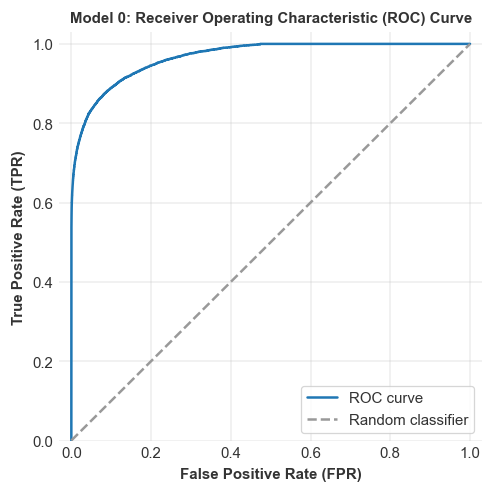

In [15]:
plot_roc_curve(p_valid_fpr, p_valid_tpr, model_idx, save=SAVE_PLOTS)

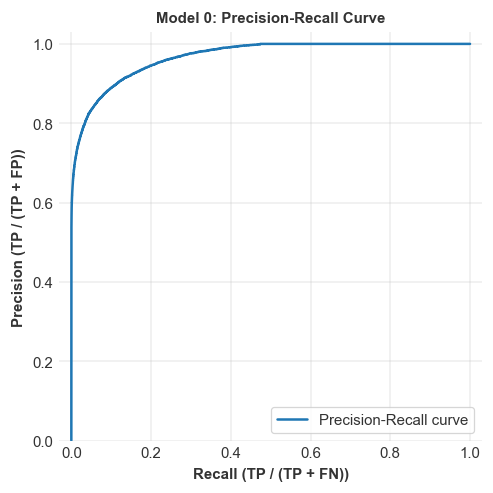

In [16]:
plot_precision_recall_curve(p_valid_fpr, p_valid_tpr, model_idx, save=SAVE_PLOTS)

#### Feature importance


In [17]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
38,no_congen,2.768145e+06
34,ca_cleft,3.930353e+05
36,ca_hypo,3.344436e+05
37,ca_disor,2.873252e+05
50,mage_c,2.451443e+05
32,ca_gast,2.081901e+05
35,ca_clpal,2.001010e+05
29,ca_cchd,1.716564e+05
30,ca_cdh,1.697453e+05
28,ca_mnsb,1.661945e+05


In [18]:
def build_explain_set(
    booster,
    X_valid,
    y_valid,
    categorical,
    n_neg_rand=100_000,
    n_neg_hard=100_000,
    seed=RANDOM_SEED,
):
    """
    Build a validation set for explanation by combining all positives,
    a random sample of negatives, and a sample of hard negatives (highest predicted
    probabilities among negatives).

    Parameters
    ----------
    booster : lightgbm.Booster
        Trained LightGBM booster.
    X_valid : pd.DataFrame
        Validation feature set.
    y_valid : pd.Series
        Validation target values.
    categorical : list of str
        List of categorical feature names.
    n_neg_rand : int
        Number of random negatives to include.
    n_neg_hard : int
        Number of hard negatives to include.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    X_explain : pd.DataFrame
        Explanation feature set.
    y_explain : pd.Series
        Explanation target values.
    """
    rng = np.random.default_rng(seed)

    yv = np.asarray(y_valid)
    idx_pos = np.flatnonzero(yv == 1)
    idx_neg = np.flatnonzero(yv == 0)

    # predict once on valid to pick hard negatives
    p_valid = booster.predict(X_valid, num_iteration=booster.best_iteration)

    # random negatives
    n_neg_rand = min(n_neg_rand, idx_neg.size)
    idx_neg_rand = rng.choice(idx_neg, size=n_neg_rand, replace=False)

    # hard negatives (top predicted p among negatives)
    n_neg_hard = min(n_neg_hard, idx_neg.size)
    p_neg = p_valid[idx_neg]
    hard_local = np.argpartition(p_neg, -n_neg_hard)[-n_neg_hard:]
    idx_neg_hard = idx_neg[hard_local]

    idx = np.unique(np.concatenate([idx_pos, idx_neg_rand, idx_neg_hard]))
    rng.shuffle(idx)

    X_eval = X_valid.iloc[idx].astype(np.float64).replace({pd.NA: np.nan}).copy()
    X_eval[categorical] = X_eval[categorical].astype("category")
    y_eval = pd.Series(yv[idx], index=X_valid.index[idx])
    return X_eval, y_eval

## Evaluation subset for permutation importances and SHAP analysis


In [19]:
X_eval, y_eval = build_explain_set(gbm, X_valid, y_valid, categorical)

In [ ]:
model_wrapped = LGBMEstimator(gbm)

In [21]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ap_scorer,
    n_repeats=10,
    n_jobs=NUM_THREADS,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/permutation_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
38,no_congen,5.138450e-01,0.000943
29,ca_cchd,1.906947e-01,0.001258
37,ca_disor,1.789053e-01,0.001724
34,ca_cleft,1.738339e-01,0.002465
35,ca_clpal,1.293521e-01,0.002154
36,ca_hypo,1.266582e-01,0.001919
30,ca_cdh,1.245836e-01,0.002111
28,ca_mnsb,1.200985e-01,0.002289
31,ca_omph,1.048304e-01,0.002657
33,ca_limb,9.984892e-02,0.001886


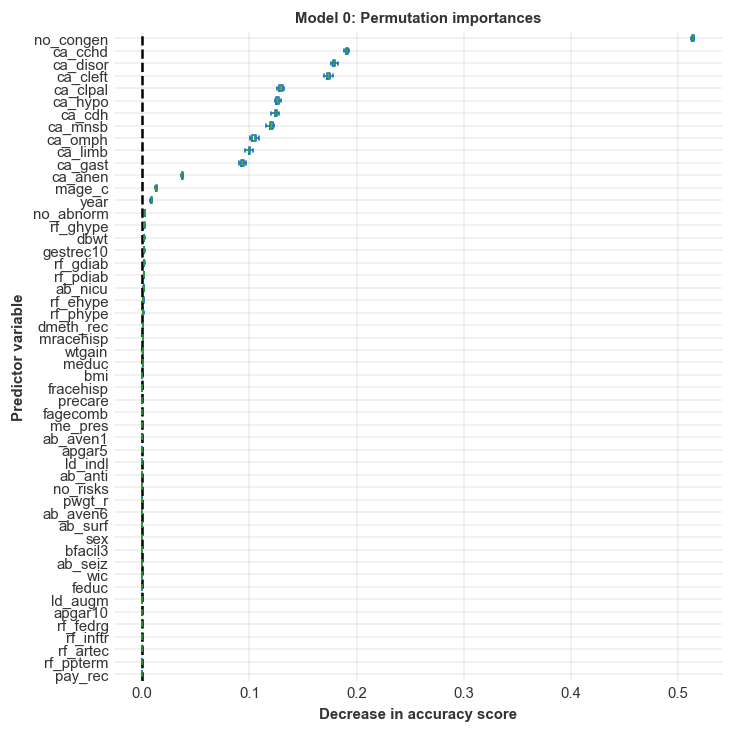

In [22]:
plot_permutation_importances(result, X_eval, model_idx, save=SAVE_PLOTS)

In [23]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.ward(condensed)

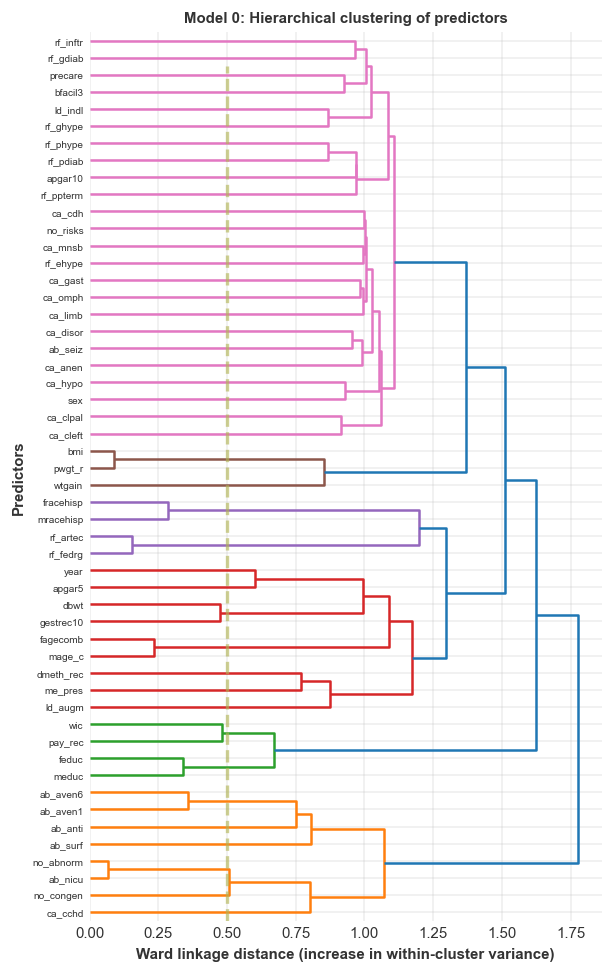

In [24]:
plt.figure(figsize=(5, 8))
dendro_0 = hierarchy.dendrogram(
    dist_linkage, labels=X_eval.columns.to_list(), orientation="right", ax=plt.axes()
)
plt.vlines(0.5, 0, 500, linestyle="--", color="#b2b4549f", linewidth=2)
plt.xlabel("Ward linkage distance (increase in within-cluster variance)")
plt.ylabel("Predictors")
plt.title(f"Model {model_idx}: Hierarchical clustering of predictors")
plt.show()

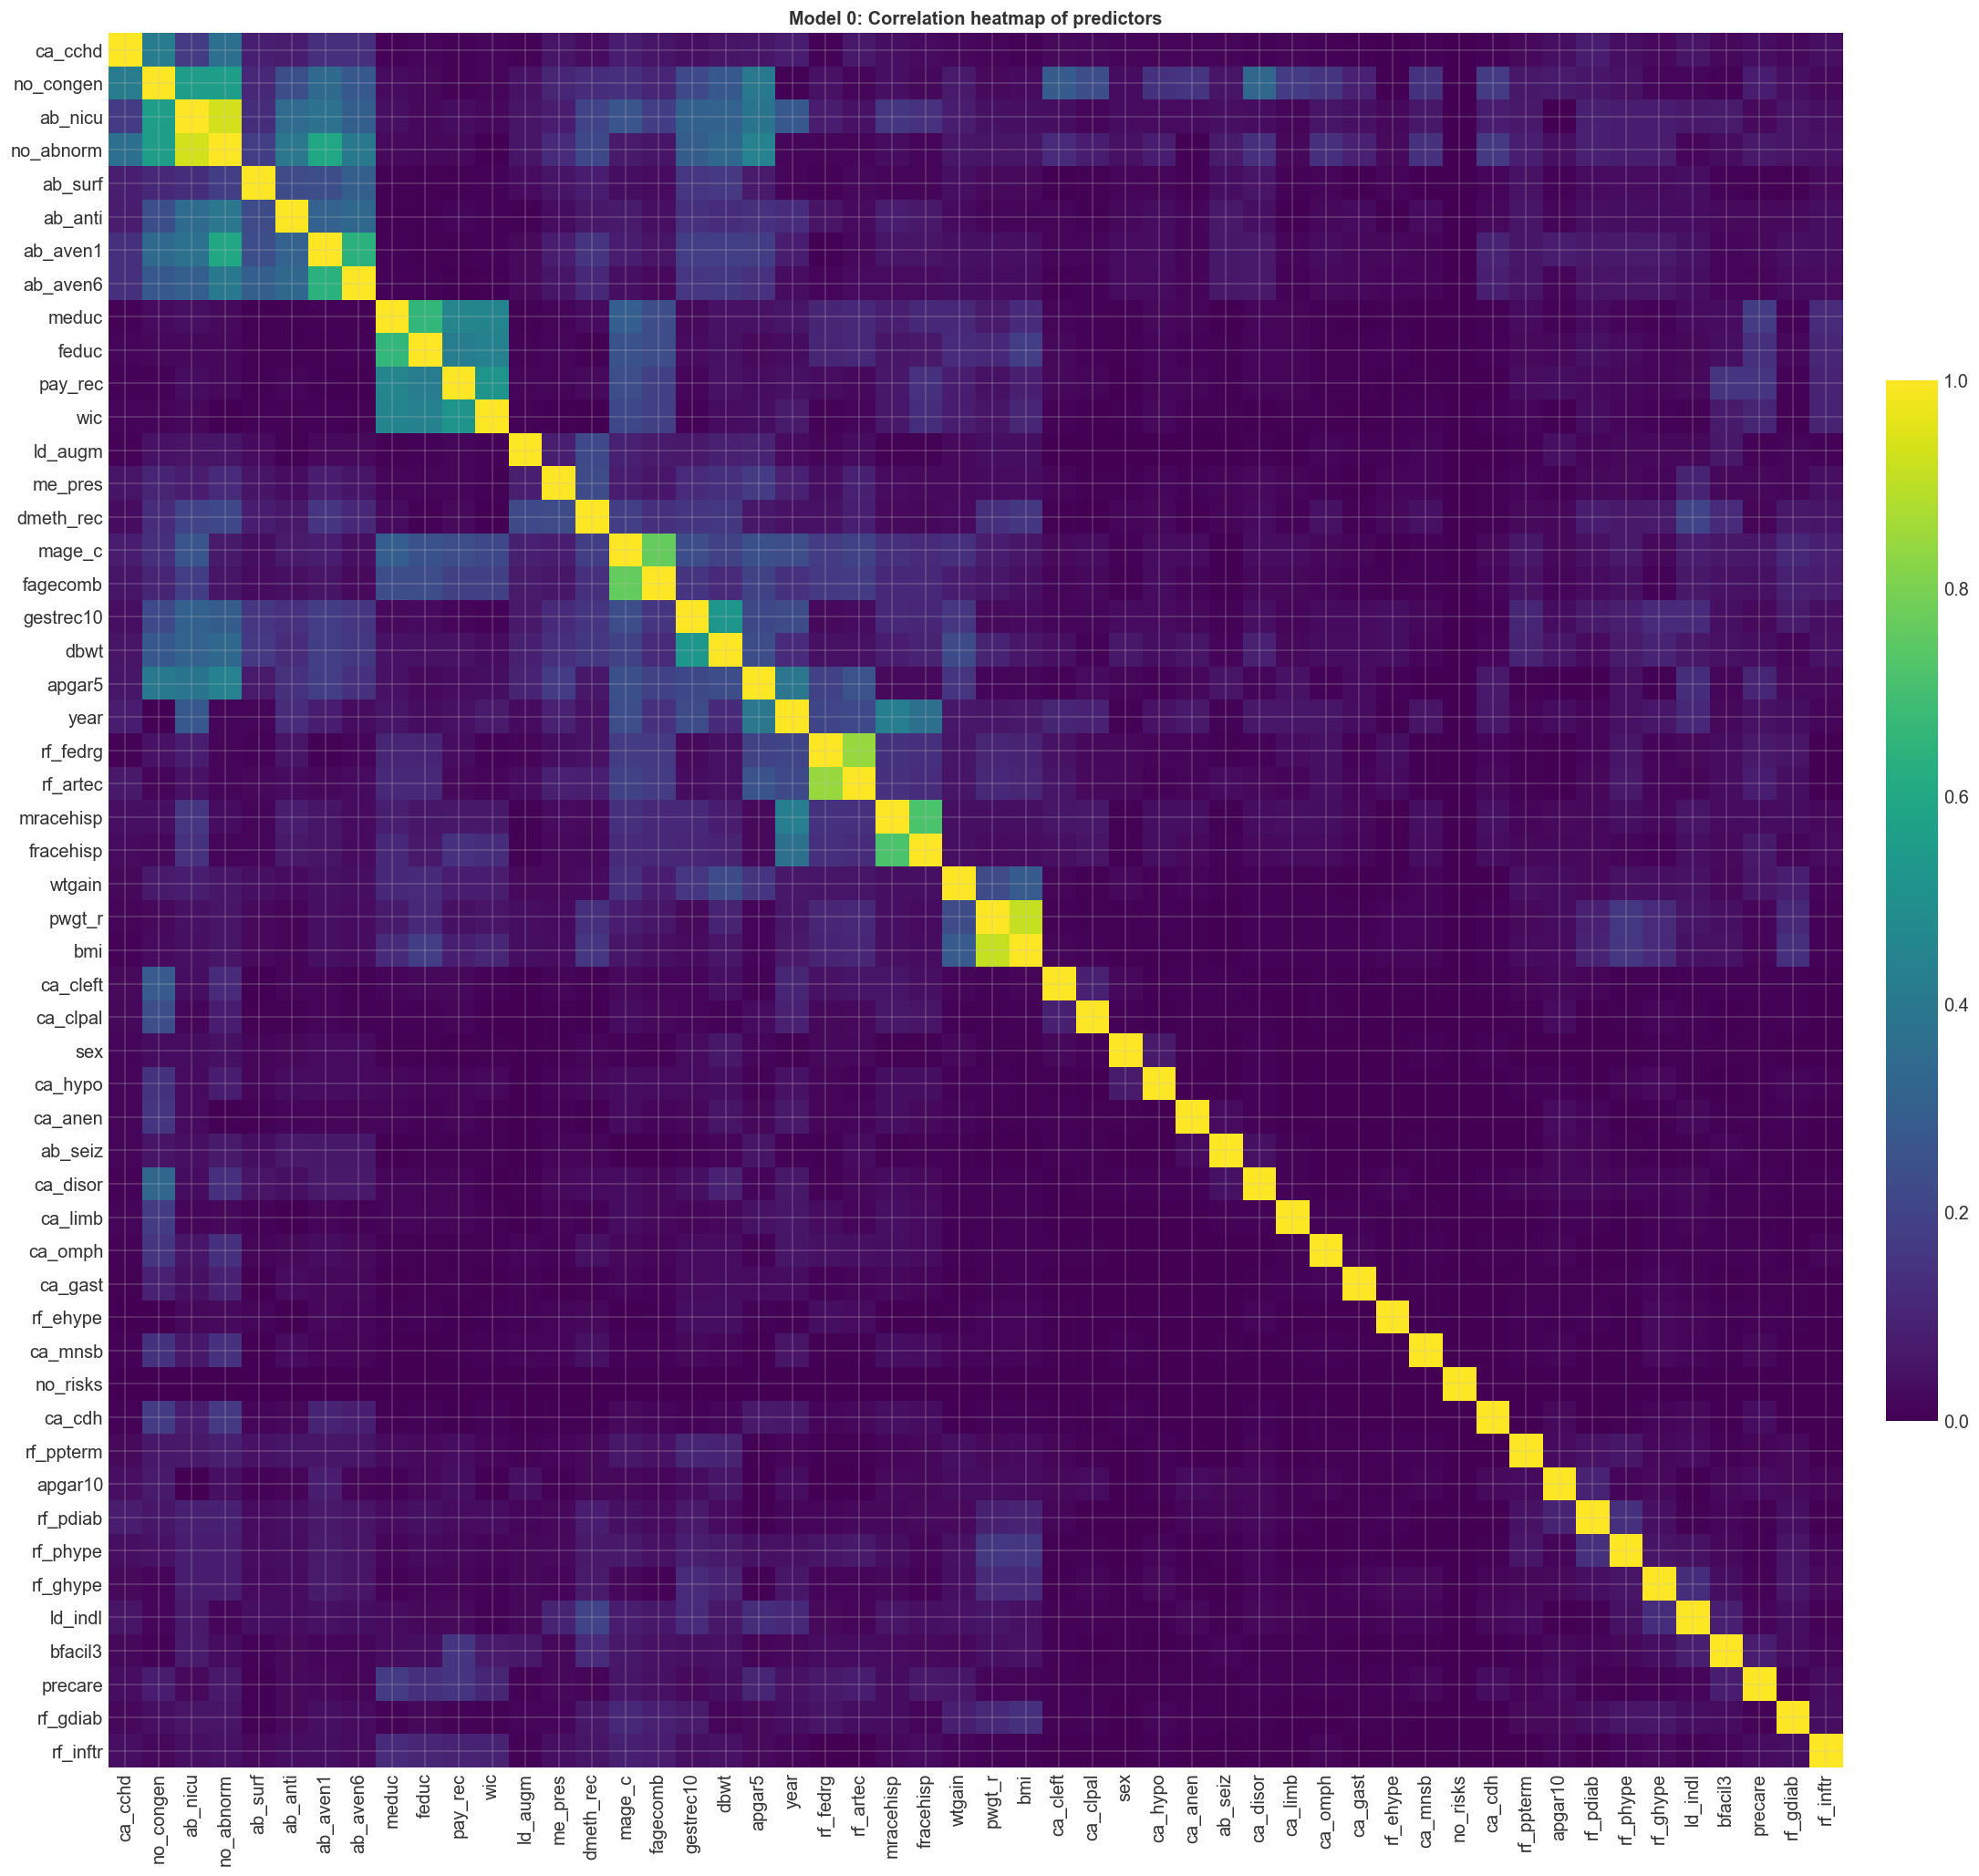

In [25]:
dendro_idx = np.arange(0, len(dendro_0["ivl"]))

with plt.rc_context(
    {"ytick.labelsize": 12, "xtick.labelsize": 12, "axes.titlesize": 12}
):
    plt.figure(figsize=(18, 18))
    plt.set_cmap("viridis")
    ax = plt.axes()
    im = ax.imshow(corr[dendro_0["leaves"], :][:, dendro_0["leaves"]])
    ax.set_title(f"Model {model_idx}: Correlation heatmap of predictors")
    ax.set_xticks(dendro_idx)
    ax.set_yticks(dendro_idx)
    ax.set_xticklabels(dendro_0["ivl"], rotation="vertical")
    ax.set_yticklabels(dendro_0["ivl"])
    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.025)
    plt.show()

In [26]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
38,no_congen,3.541387
50,mage_c,0.562896
22,ab_nicu,0.444460
46,dbwt,0.267267
37,ca_disor,0.254874
3,gestrec10,0.187821
29,ca_cchd,0.110322
45,year,0.106200
34,ca_cleft,0.087019
20,ab_aven1,0.083372


In [27]:
shap_importance["feature"].tolist()

['no_congen',
 'mage_c',
 'ab_nicu',
 'dbwt',
 'ca_disor',
 'gestrec10',
 'ca_cchd',
 'year',
 'ca_cleft',
 'ab_aven1',
 'rf_pdiab',
 'no_abnorm',
 'rf_ghype',
 'ca_clpal',
 'ca_omph',
 'wtgain',
 'ca_cdh',
 'ca_limb',
 'ca_hypo',
 'mracehisp',
 'ab_anti',
 'ca_anen',
 'fracehisp',
 'precare',
 'ca_gast',
 'ca_mnsb',
 'pwgt_r',
 'dmeth_rec',
 'meduc',
 'rf_gdiab',
 'fagecomb',
 'bmi',
 'bfacil3',
 'rf_ehype',
 'apgar5',
 'rf_phype',
 'ab_aven6',
 'ld_indl',
 'me_pres',
 'feduc',
 'sex',
 'ab_seiz',
 'ld_augm',
 'pay_rec',
 'ab_surf',
 'rf_inftr',
 'rf_artec',
 'no_risks',
 'rf_ppterm',
 'wic',
 'apgar10',
 'rf_fedrg']

We cannot plot millions of observations, so for SHAP analysis, we take a random selection of 10,000 positives and 50,000 negatives.


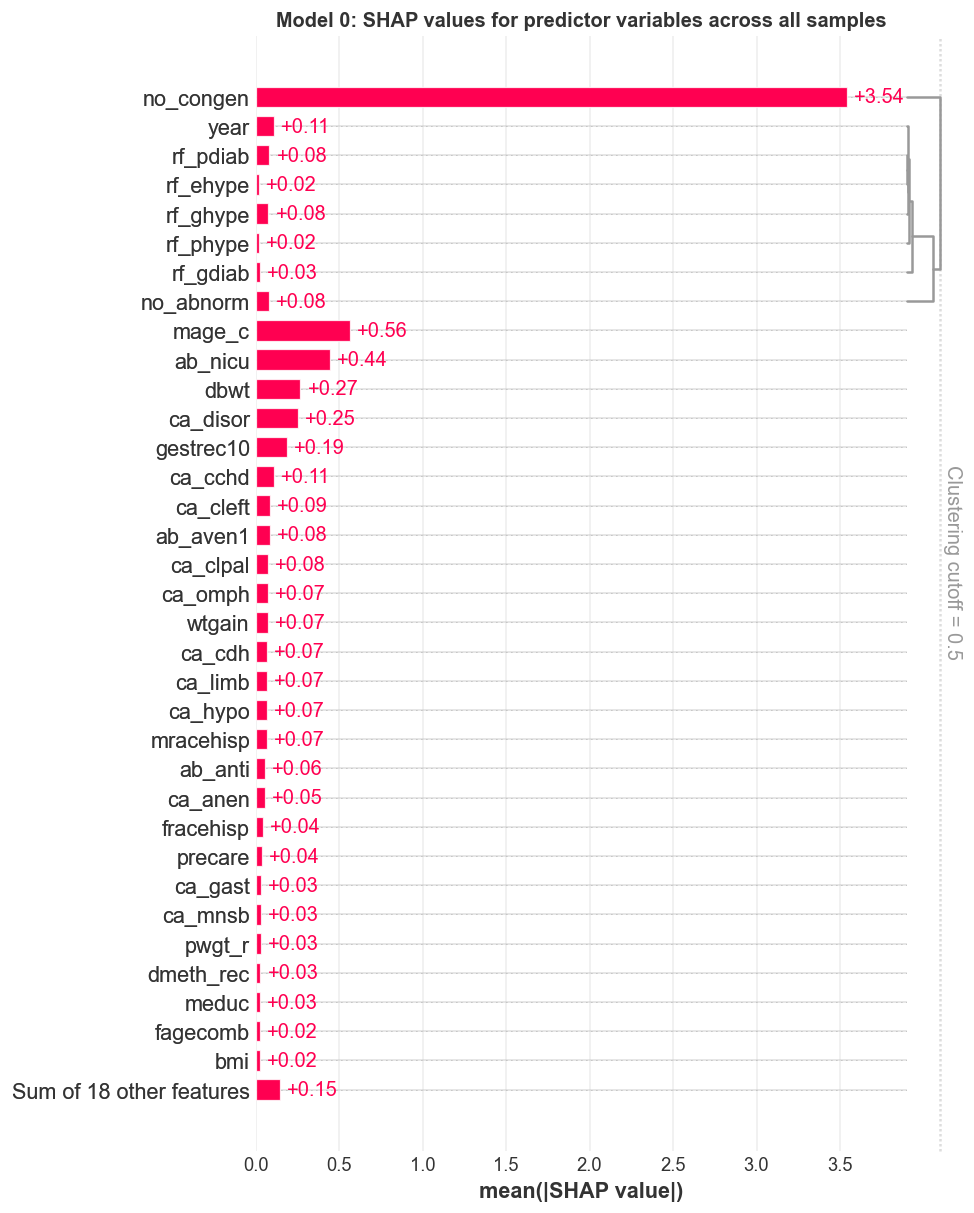

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 10))
    ax = plot.subplots()
    ax.set_title(f"Model 0: SHAP values for predictor variables")
    shap.plots.bar(explanation, clustering=clustering, max_display=35, ax=ax)

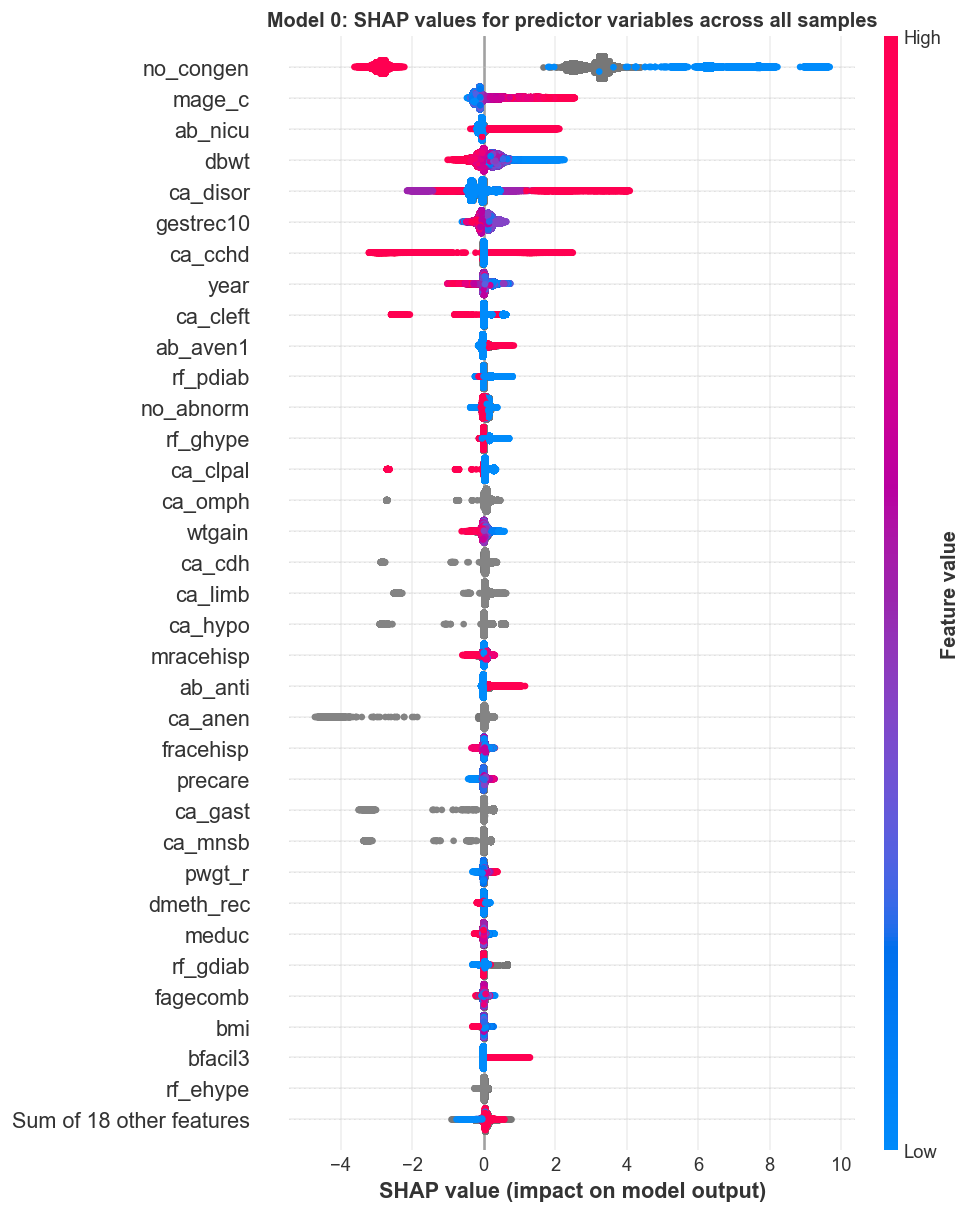

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(
        f"Model {model_idx}: SHAP values for predictor variables"
    )
    shap.plots.beeswarm(explanation, max_display=35, plot_size=(8, 10))

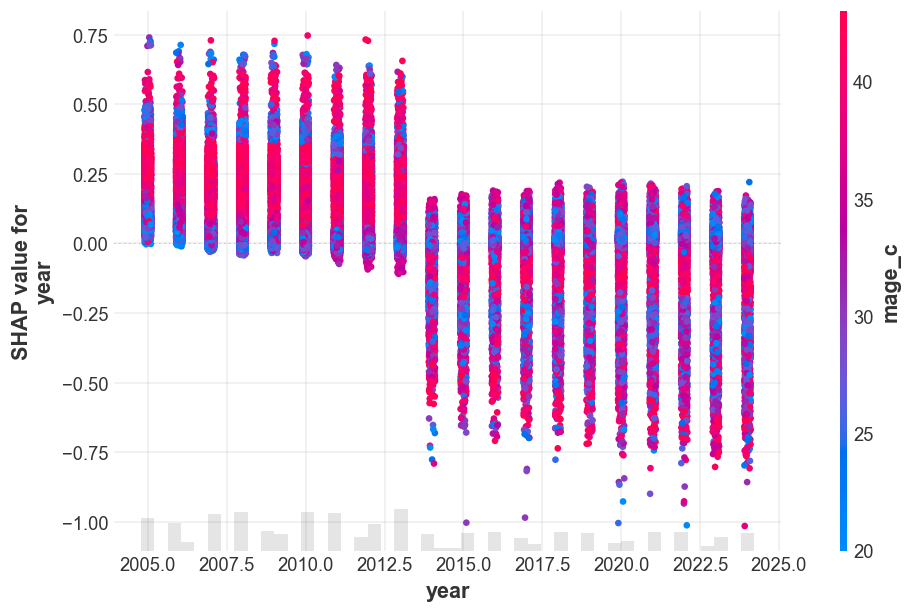

In [30]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])

## Model 1


In [31]:
features_to_remove_0 = [
    "fracehisp",  # correlated with mracehisp
    "ab_aven6",  # correlated with ab_aven1
    "pwgt_r",  # low importance, correlated with bmi
    "ld_indl",  # low importance
    "no_risks",  # low importance
    "feduc",  # low importance, correlated with meduc
    "pay_rec",  # low importance
    "rf_ghype",  # low importance
    "ab_surf",  # low importance
    "rf_inftr",  # low importance
    "ld_augm",  # low importance
    "rf_gdiab",  # low importance
    "sex",  # low importance
    "ab_seiz",  # low importance
    "rf_ppterm",  # low importance
    "wic",  # low importance
    "rf_artec",  # low importance
    "rf_fedrg",  # low importance
    "apgar10",  # low importance, low SHAP value
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['fracehisp', 'ab_aven6', 'pwgt_r', 'ld_indl', 'no_risks', 'feduc', 'pay_rec', 'rf_ghype', 'ab_surf', 'rf_inftr', 'ld_augm', 'rf_gdiab', 'sex', 'ab_seiz', 'rf_ppterm', 'wic', 'rf_artec', 'rf_fedrg', 'apgar10']
Features remaining: ['bfacil3', 'precare', 'gestrec10', 'rf_pdiab', 'rf_phype', 'rf_ehype', 'me_pres', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_nicu', 'ab_anti', 'no_abnorm', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 'ca_gast', 'ca_limb', 'ca_cleft', 'ca_clpal', 'ca_hypo', 'ca_disor', 'no_congen', 'meduc', 'mracehisp', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 1 (after removing 19 predictors): 33


In [32]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}_{datetime.now().strftime("%Y%m%d%H%M")}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[10]	train's average_precision: 0.52682	train's binary_logloss: 0.00262752	valid's average_precision: 0.521746	valid's binary_logloss: 0.00264276
[20]	train's average_precision: 0.531952	train's binary_logloss: 0.002465	valid's average_precision: 0.52664	valid's binary_logloss: 0.00248392
[30]	train's average_precision: 0.532618	train's binary_logloss: 0.00235928	valid's average_precision: 0.527096	valid's binary_logloss: 0.0023814
[40]	train's average_precision: 0.534234	train's binary_logloss: 0.0022637	valid's average_precision: 0.528433	valid's binary_logloss: 0.00228894
[50]	train's average

In [33]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [34]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.966917
1,Validation AP,0.553483
2,Validation log loss,0.001839
3,Precision at 10000,0.529800
4,Recall at 10000,0.533320
5,Precision (threshold=0.01),0.117774
6,Recall (threshold=0.01),0.624522


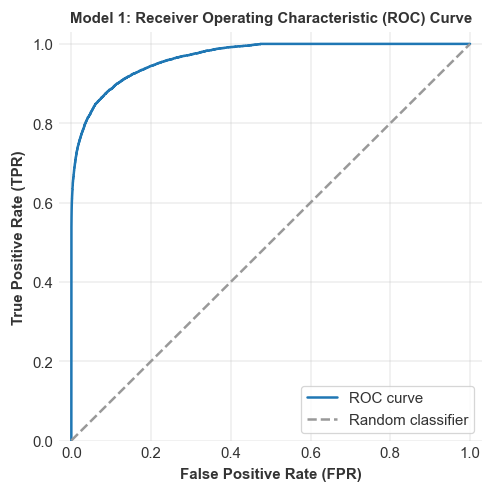

In [35]:
plot_roc_curve(p_valid_fpr, p_valid_tpr, model_idx, save=SAVE_PLOTS)

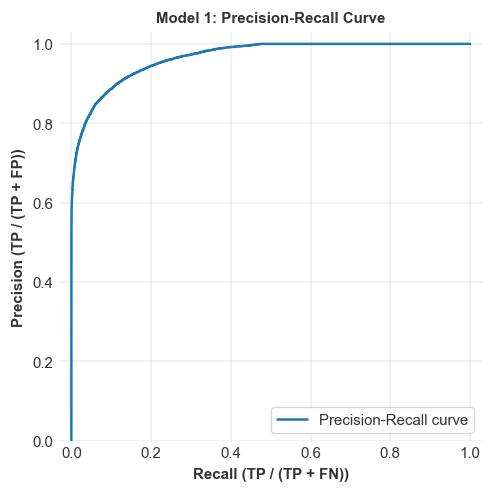

In [36]:
plot_precision_recall_curve(p_valid_fpr, p_valid_tpr, model_idx, save=SAVE_PLOTS)

In [37]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
24,no_congen,2.789180e+06
15,ca_cchd,3.506487e+05
20,ca_cleft,2.943114e+05
23,ca_disor,2.902078e+05
31,mage_c,2.753153e+05
22,ca_hypo,2.178924e+05
18,ca_gast,1.916641e+05
21,ca_clpal,1.819103e+05
14,ca_mnsb,1.534614e+05
10,ab_nicu,1.419189e+05


In [ ]:
X_eval, y_eval = build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = LGBMEstimator(gbm)

In [39]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ap_scorer,
    n_repeats=10,
    n_jobs=NUM_THREADS,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/permutation_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
24,no_congen,0.492871,0.001672
15,ca_cchd,0.226053,0.003021
23,ca_disor,0.181230,0.002188
20,ca_cleft,0.169500,0.002150
21,ca_clpal,0.125559,0.002314
14,ca_mnsb,0.099846,0.001479
19,ca_limb,0.091184,0.001509
13,ca_anen,0.079637,0.001447
18,ca_gast,0.076654,0.001927
22,ca_hypo,0.069304,0.001086


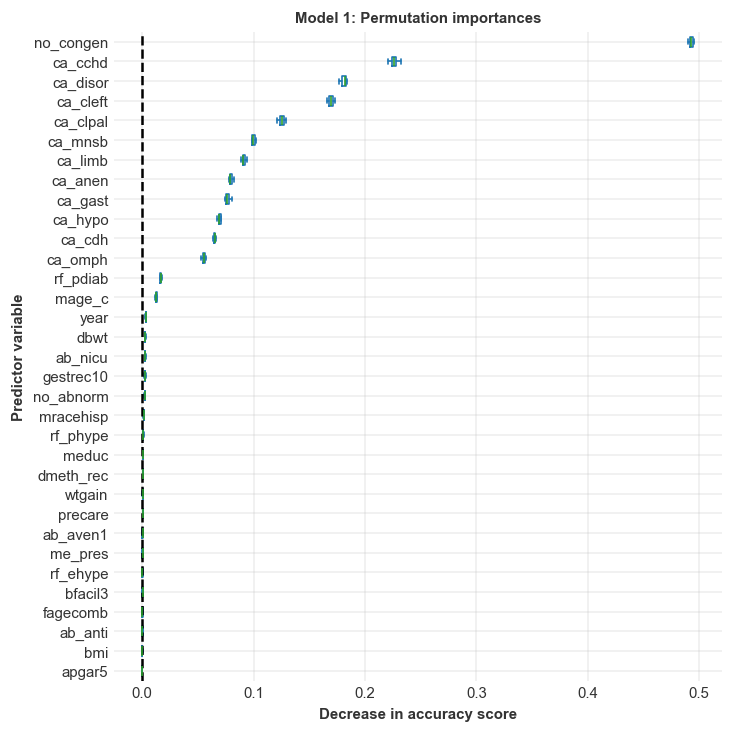

In [40]:
plot_permutation_importances(result, X_eval, model_idx, save=SAVE_PLOTS)

In [41]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.ward(condensed)

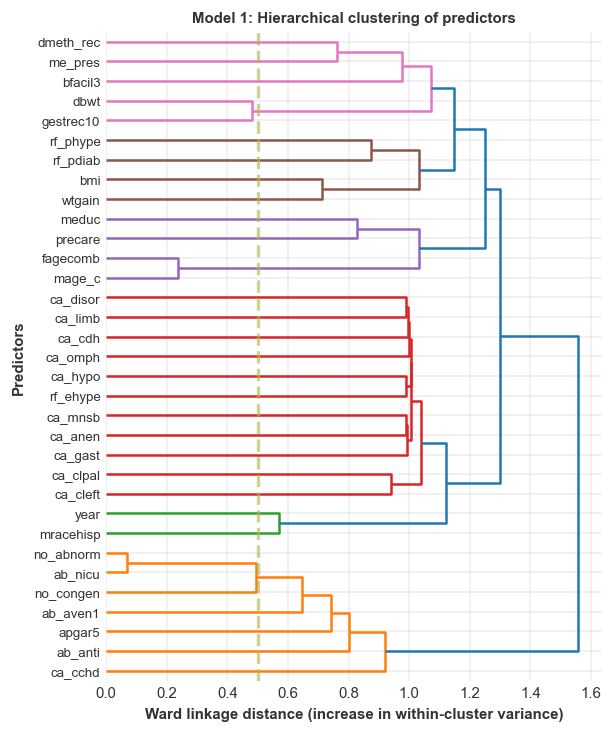

In [42]:
plt.figure(figsize=(5, 6))
dendro_0 = hierarchy.dendrogram(
    dist_linkage, labels=X_eval.columns.to_list(), orientation="right", ax=plt.axes()
)
plt.vlines(0.5, 0, 500, linestyle="--", color="#b2b4549f", linewidth=2)
plt.xlabel("Ward linkage distance (increase in within-cluster variance)")
plt.ylabel("Predictors")
plt.title(f"Model {model_idx}: Hierarchical clustering of predictors")
plt.show()

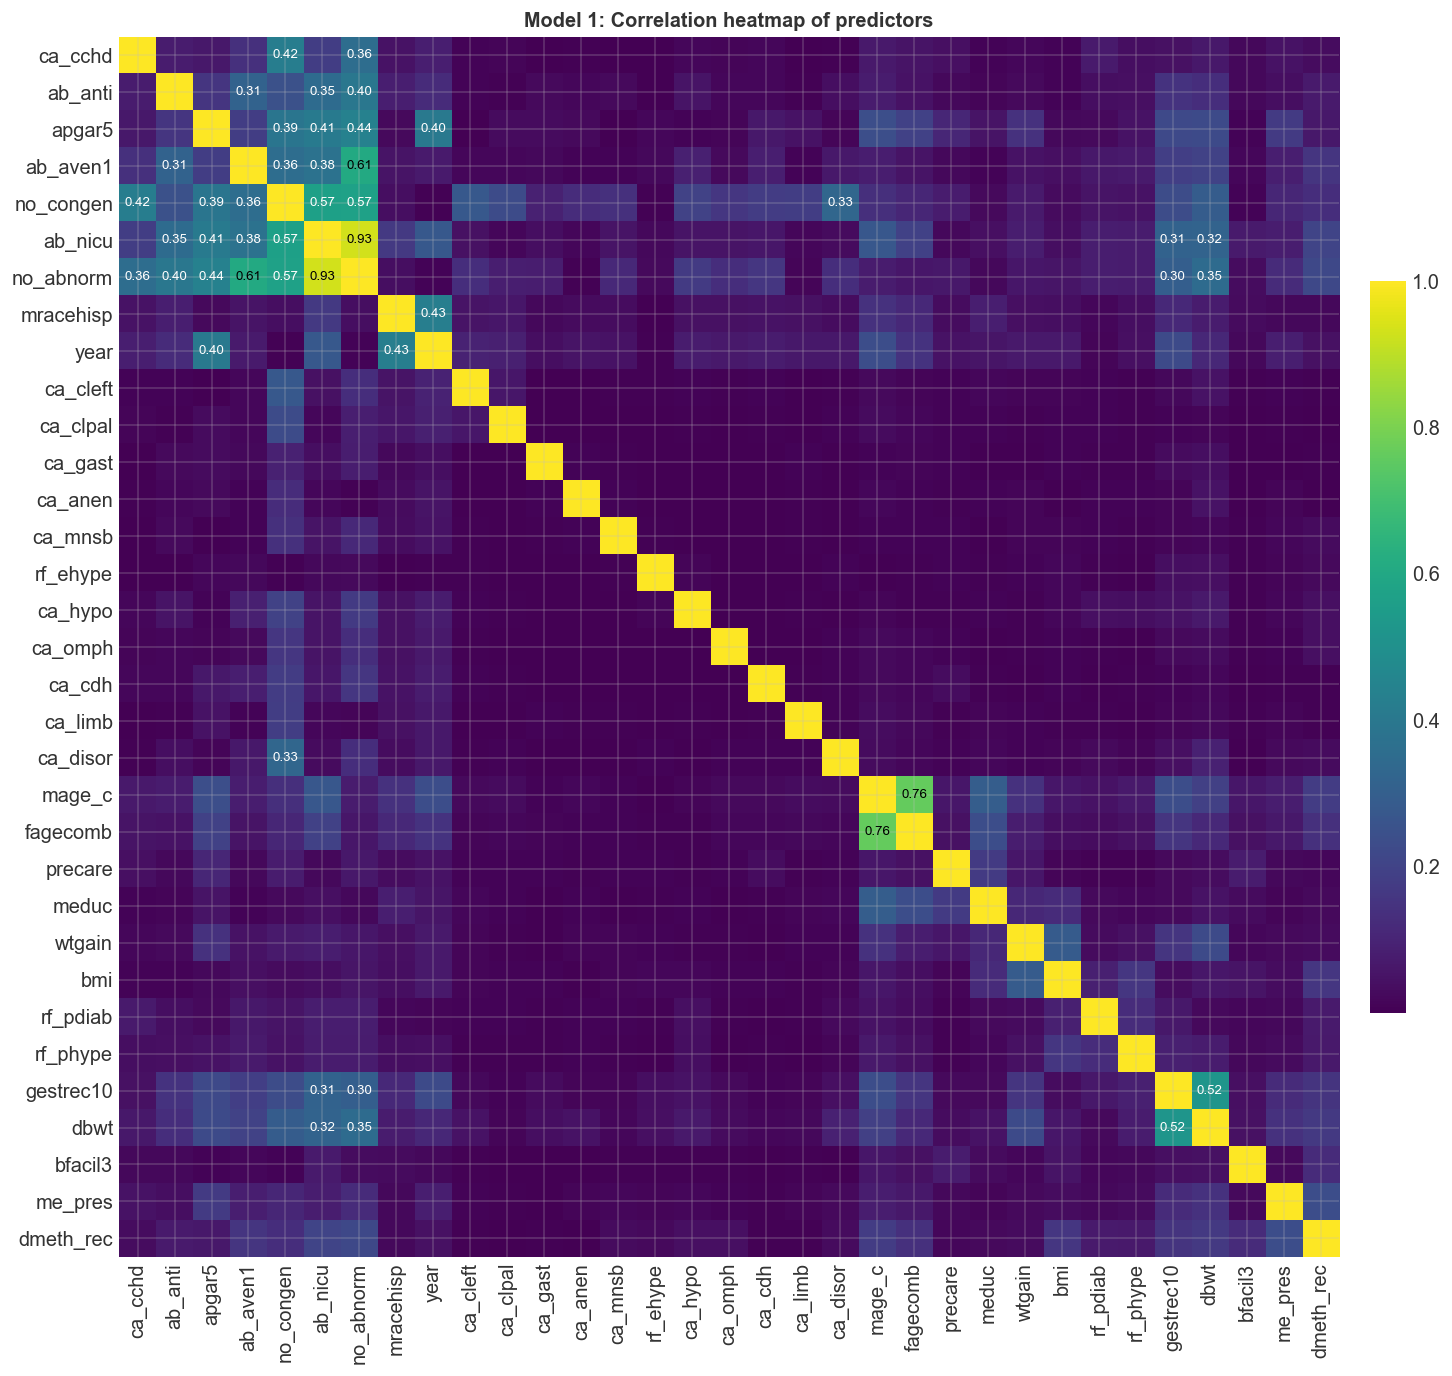

In [43]:
C = corr[dendro_0["leaves"], :][:, dendro_0["leaves"]]
labels = dendro_0["ivl"]
dendro_idx = np.arange(len(labels))

threshold = 0.30  # adjust: 0.4, 0.5, 0.6 ...

with plt.rc_context(
    {"ytick.labelsize": 12, "xtick.labelsize": 12, "axes.titlesize": 12}
):
    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(C, cmap="viridis")

    ax.set_title(f"Model {model_idx}: Correlation heatmap of predictors")
    ax.set_xticks(dendro_idx)
    ax.set_yticks(dendro_idx)
    ax.set_xticklabels(labels, rotation="vertical")
    ax.set_yticklabels(labels)

    n = C.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue  # skip diagonal
            if abs(C[i, j]) < threshold:
                continue

            ax.text(
                j,
                i,
                f"{C[i, j]:.2f}",
                ha="center",
                va="center",
                fontsize=8,
                color="white" if abs(C[i, j]) < 0.6 else "black",
            )

    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.025)
    plt.show()

In [44]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
24,no_congen,4.106843
31,mage_c,0.579604
10,ab_nicu,0.490284
28,dbwt,0.263280
3,rf_pdiab,0.232747
2,gestrec10,0.194050
15,ca_cchd,0.161266
23,ca_disor,0.159801
26,mracehisp,0.097251
9,ab_aven1,0.080492


In [45]:
shap_importance["feature"].tolist()

['no_congen',
 'mage_c',
 'ab_nicu',
 'dbwt',
 'rf_pdiab',
 'gestrec10',
 'ca_cchd',
 'ca_disor',
 'mracehisp',
 'ab_aven1',
 'ca_cleft',
 'wtgain',
 'ca_hypo',
 'ca_omph',
 'ab_anti',
 'year',
 'ca_clpal',
 'no_abnorm',
 'ca_cdh',
 'precare',
 'bmi',
 'rf_phype',
 'meduc',
 'fagecomb',
 'ca_limb',
 'dmeth_rec',
 'ca_mnsb',
 'ca_gast',
 'bfacil3',
 'ca_anen',
 'apgar5',
 'me_pres',
 'rf_ehype']

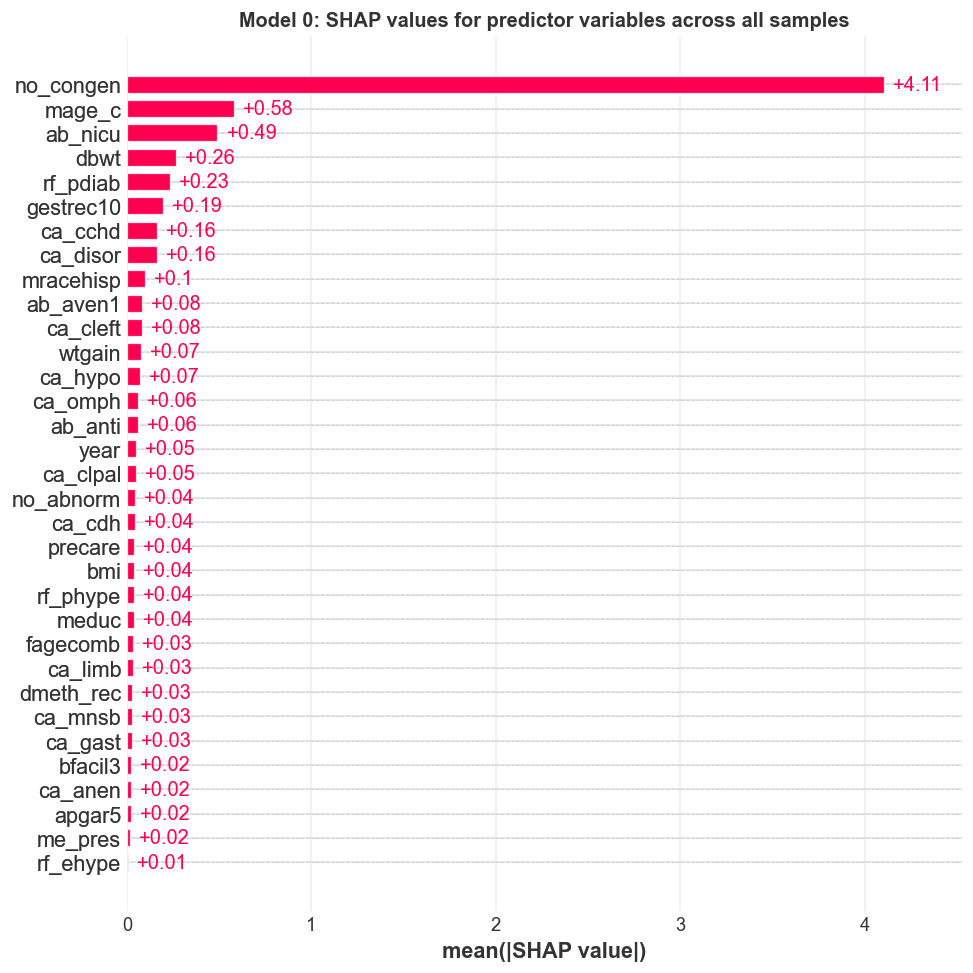

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)

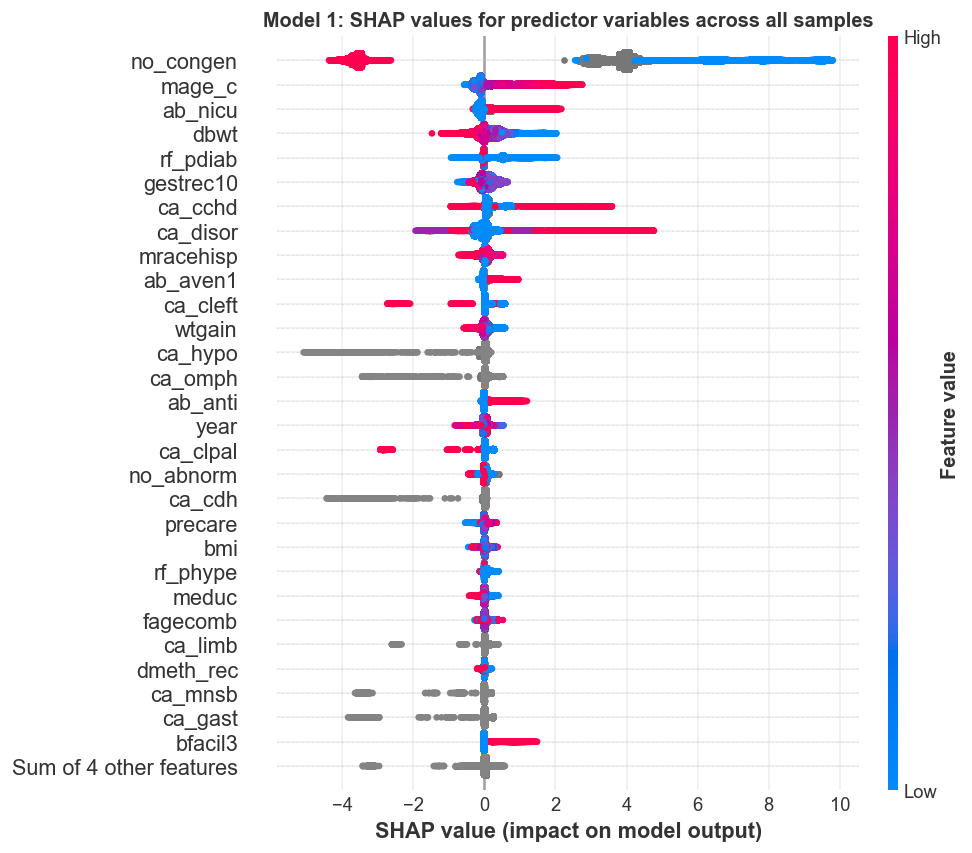

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(
        f"Model {model_idx}: SHAP values for predictor variables"
    )
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))

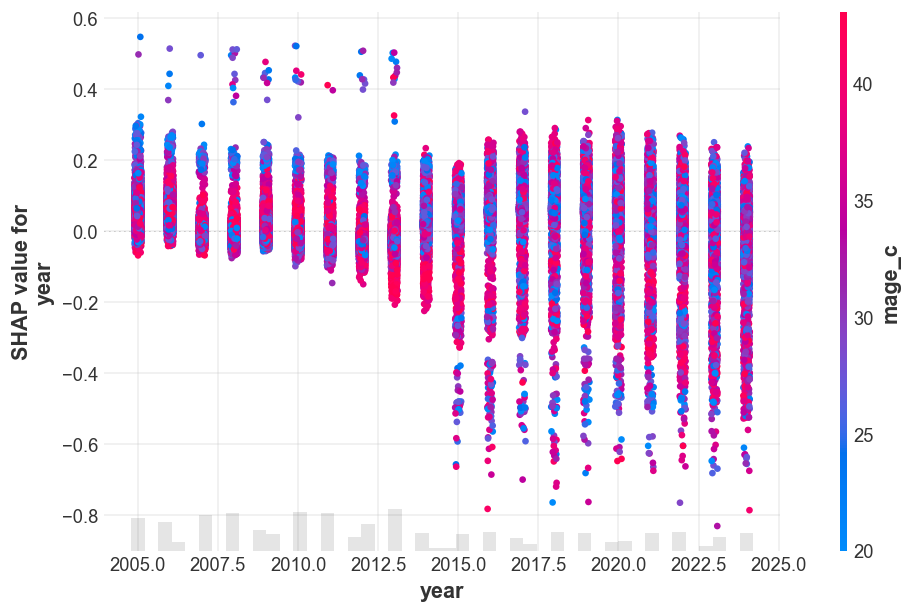

In [48]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])

## Model 2


In [49]:
features_to_remove_1 = [
    "precare",  # low importance, low SHAP value
    "bmi",  # low importance, low SHAP value
    "meduc",  # low importance, low SHAP value
    "fagecomb",  # low importance, low SHAP value, correlated with mage_c
    "rf_pdiab",  # low importance, low SHAP value
    "apgar5",  # low importance, low SHAP value
    "bfacil3",  # low importance, low SHAP value
    "dmeth_rec",  # low importance, low SHAP value
    "rf_phype",  # low importance, low SHAP value
    "me_pres",  # low importance, low SHAP value
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['precare', 'bmi', 'meduc', 'fagecomb', 'rf_pdiab', 'apgar5', 'bfacil3', 'dmeth_rec', 'rf_phype', 'me_pres']
Features remaining: ['gestrec10', 'rf_ehype', 'ab_aven1', 'ab_nicu', 'ab_anti', 'no_abnorm', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 'ca_gast', 'ca_limb', 'ca_cleft', 'ca_clpal', 'ca_hypo', 'ca_disor', 'no_congen', 'mracehisp', 'year', 'dbwt', 'wtgain', 'mage_c']
Number of features in Model 2 (after removing 10 predictors): 23


In [50]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}_{datetime.now().strftime("%Y%m%d%H%M")}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	train's average_precision: 0.512265	train's binary_logloss: 0.00251424	valid's average_precision: 0.507434	valid's binary_logloss: 0.00253868
[20]	train's average_precision: 0.542629	train's binary_logloss: 0.00234693	valid's average_precision: 0.537078	valid's binary_logloss: 0.00237251
[30]	train's average_precision: 0.548647	train's binary_logloss: 0.00223058	valid's average_precision: 0.542567	valid's binary_logloss: 0.0022571
[40]	train's average_precision: 0.550418	train's binary_logloss: 0.00214189	valid's ave

In [51]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [52]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.966766
1,Validation AP,0.551268
2,Validation log loss,0.001842
3,Precision at 10000,0.527800
4,Recall at 10000,0.531307
5,Precision (threshold=0.01),0.127979
6,Recall (threshold=0.01),0.617375


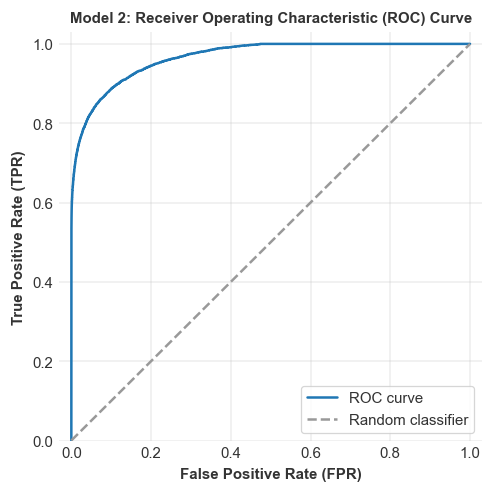

In [53]:
plot_roc_curve(p_valid_fpr, p_valid_tpr, model_idx, save=SAVE_PLOTS)

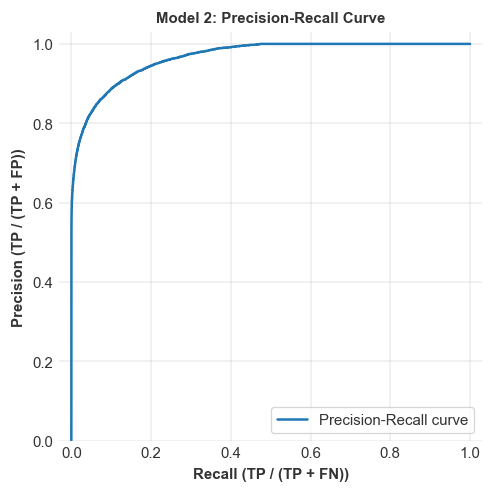

In [54]:
plot_precision_recall_curve(p_valid_fpr, p_valid_tpr, model_idx, save=SAVE_PLOTS)

In [55]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
17,no_congen,2.629545e+06
8,ca_cchd,5.077352e+05
16,ca_disor,4.086067e+05
13,ca_cleft,3.964075e+05
15,ca_hypo,3.324605e+05
11,ca_gast,2.854626e+05
14,ca_clpal,2.801213e+05
12,ca_limb,2.430975e+05
7,ca_mnsb,2.394417e+05
9,ca_cdh,2.365197e+05


In [ ]:
X_eval, y_eval = build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = LGBMEstimator(gbm)

In [57]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ap_scorer,
    n_repeats=10,
    n_jobs=NUM_THREADS,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/permutation_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
17,no_congen,0.520113,0.000532
8,ca_cchd,0.247878,0.002597
13,ca_cleft,0.165873,0.003071
16,ca_disor,0.161878,0.002477
14,ca_clpal,0.131667,0.004008
15,ca_hypo,0.122271,0.003607
9,ca_cdh,0.121107,0.003268
10,ca_omph,0.117227,0.003350
7,ca_mnsb,0.106674,0.003116
12,ca_limb,0.105905,0.002941


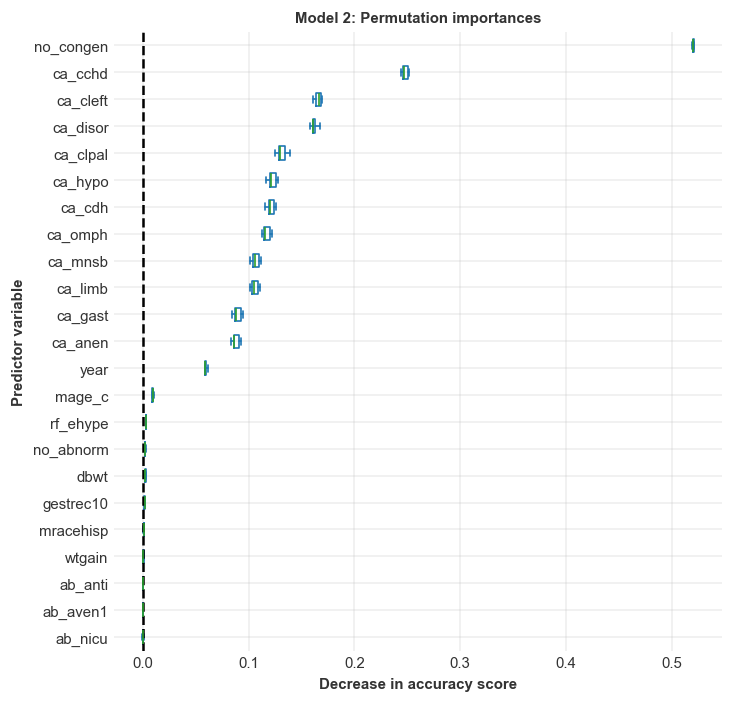

In [58]:
plot_permutation_importances(result, X_eval, model_idx, save=SAVE_PLOTS)

In [59]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.ward(condensed)

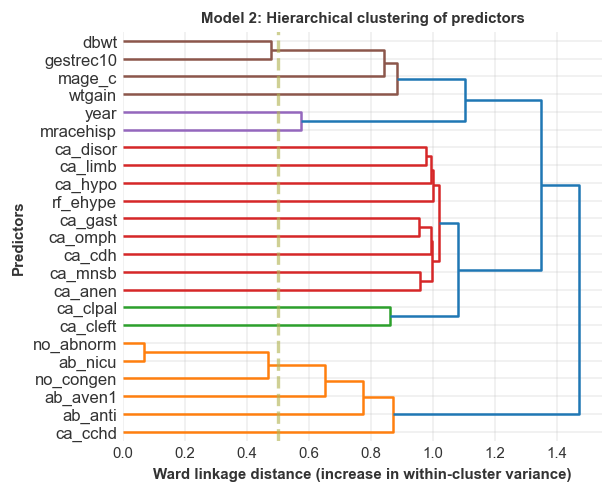

In [60]:
plt.figure(figsize=(5, 4))
dendro_0 = hierarchy.dendrogram(
    dist_linkage, labels=X_eval.columns.to_list(), orientation="right", ax=plt.axes()
)
plt.vlines(0.5, 0, 500, linestyle="--", color="#b2b4549f", linewidth=2)
plt.xlabel("Ward linkage distance (increase in within-cluster variance)")
plt.ylabel("Predictors")
plt.title(f"Model {model_idx}: Hierarchical clustering of predictors")
plt.show()

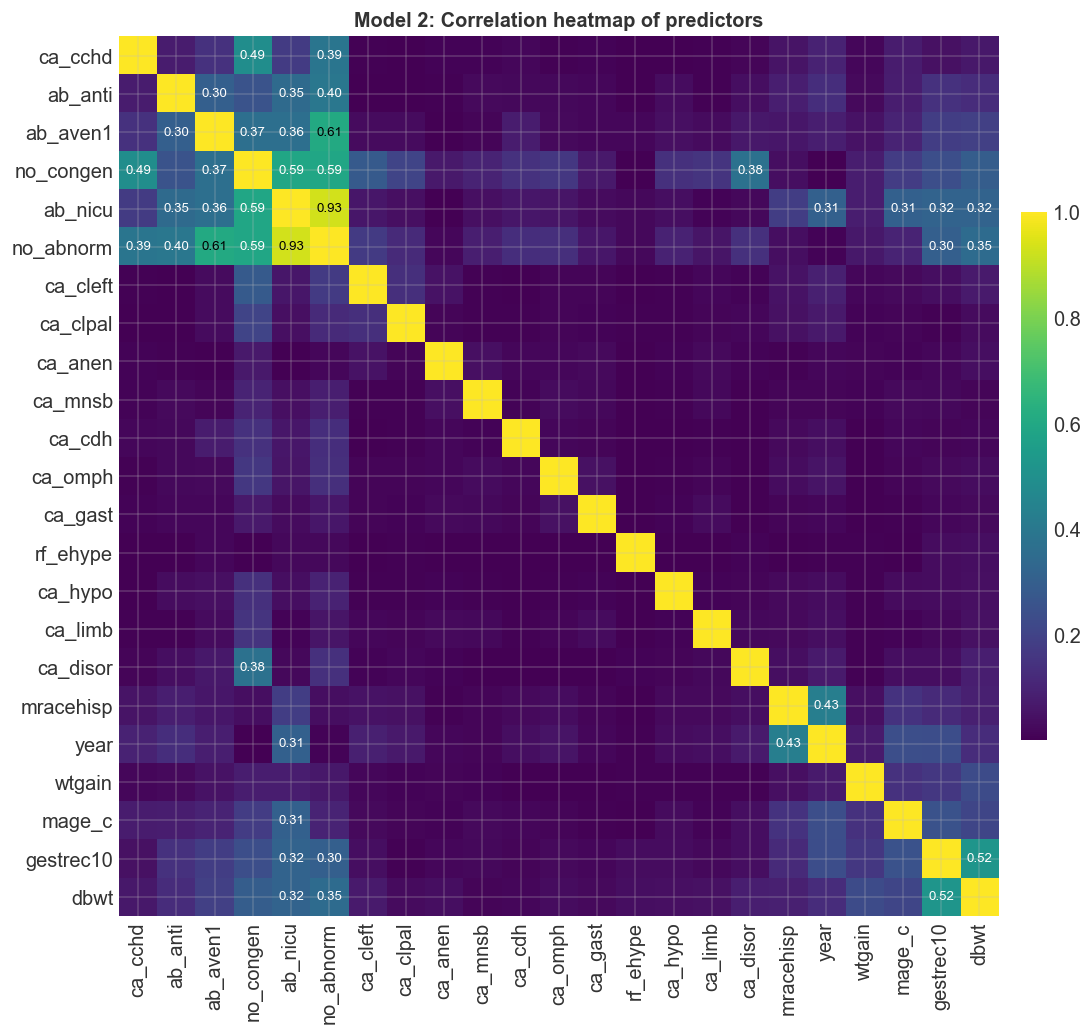

In [ ]:
C = corr[dendro_0["leaves"], :][:, dendro_0["leaves"]]
labels = dendro_0["ivl"]
dendro_idx = np.arange(len(labels))

threshold = 0.30  # adjust: 0.4, 0.5, 0.6 ...

with plt.rc_context(
    {"ytick.labelsize": 12, "xtick.labelsize": 12, "axes.titlesize": 12}
):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(C, cmap="viridis")

    ax.set_title(f"Model {model_idx}: Correlation heatmap of predictors")
    ax.set_xticks(dendro_idx)
    ax.set_yticks(dendro_idx)
    ax.set_xticklabels(labels, rotation="vertical")
    ax.set_yticklabels(labels)

    n = C.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue  # skip diagonal
            if abs(C[i, j]) < threshold:
                continue

            ax.text(
                j,
                i,
                f"{C[i, j]:.2f}",
                ha="center",
                va="center",
                fontsize=8,
                color="white" if abs(C[i, j]) < 0.6 else "black",
            )

    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.025)
    plt.show()

In [62]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 3 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
17,no_congen,3.020011
22,mage_c,0.585484
3,ab_nicu,0.499846
20,dbwt,0.266276
19,year,0.195941
0,gestrec10,0.180587
8,ca_cchd,0.150707
5,no_abnorm,0.098695
18,mracehisp,0.098022
16,ca_disor,0.093925


In [63]:
shap_importance["feature"].tolist()

['no_congen',
 'mage_c',
 'ab_nicu',
 'dbwt',
 'year',
 'gestrec10',
 'ca_cchd',
 'no_abnorm',
 'mracehisp',
 'ca_disor',
 'ab_aven1',
 'wtgain',
 'ca_cleft',
 'rf_ehype',
 'ab_anti',
 'ca_hypo',
 'ca_clpal',
 'ca_gast',
 'ca_omph',
 'ca_limb',
 'ca_cdh',
 'ca_mnsb',
 'ca_anen']

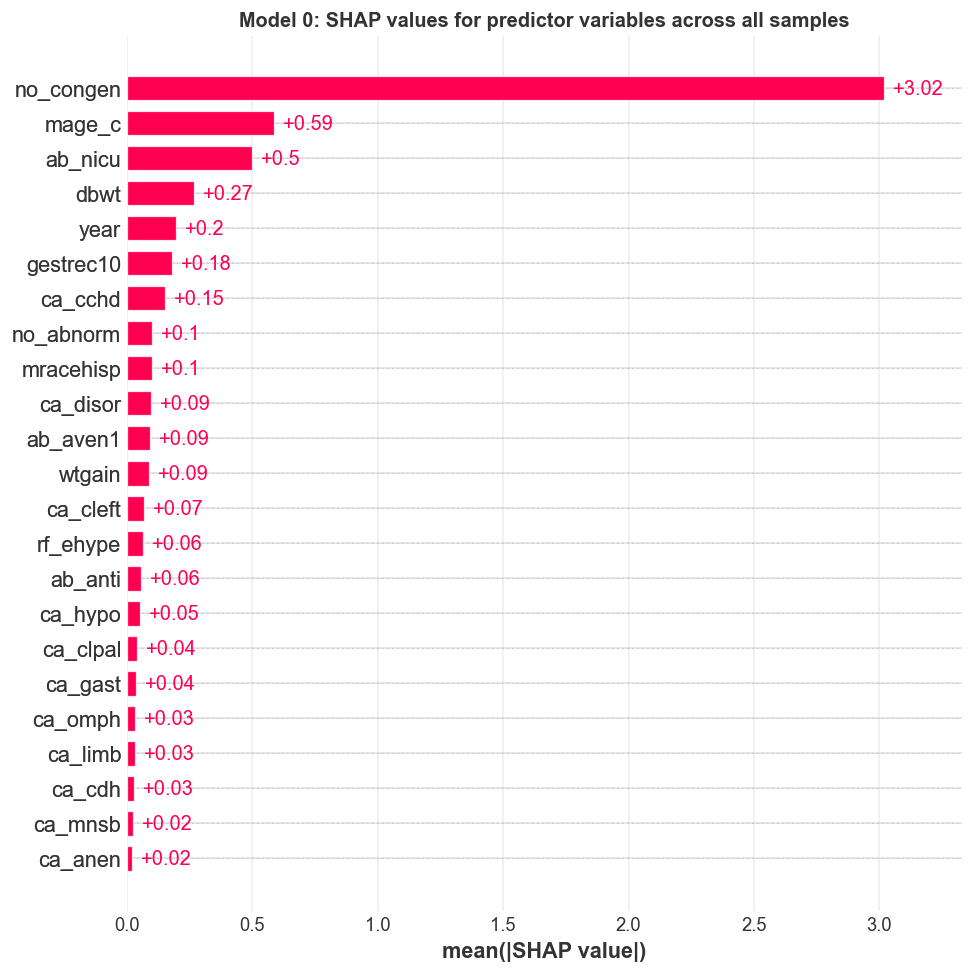

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(
        f"Model {model_idx}: SHAP values for predictor variables"
    )
    shap.plots.bar(explanation, max_display=35, ax=ax)

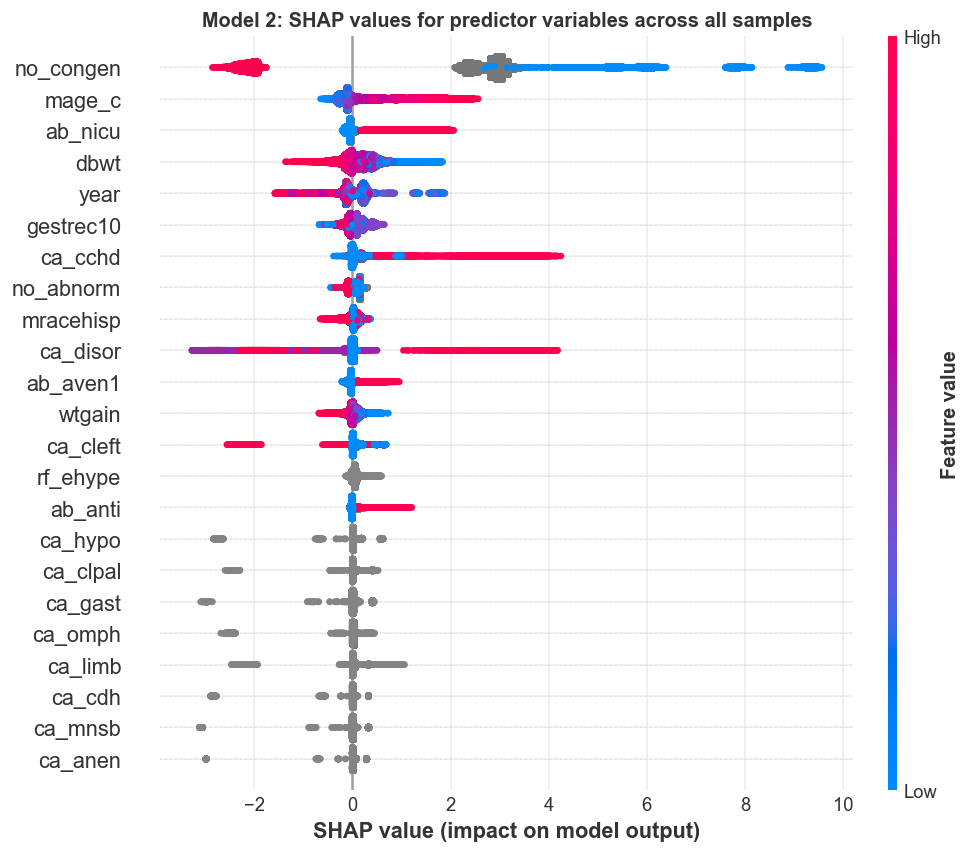

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(
        f"Model {model_idx}: SHAP values for predictor variables"
    )
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))

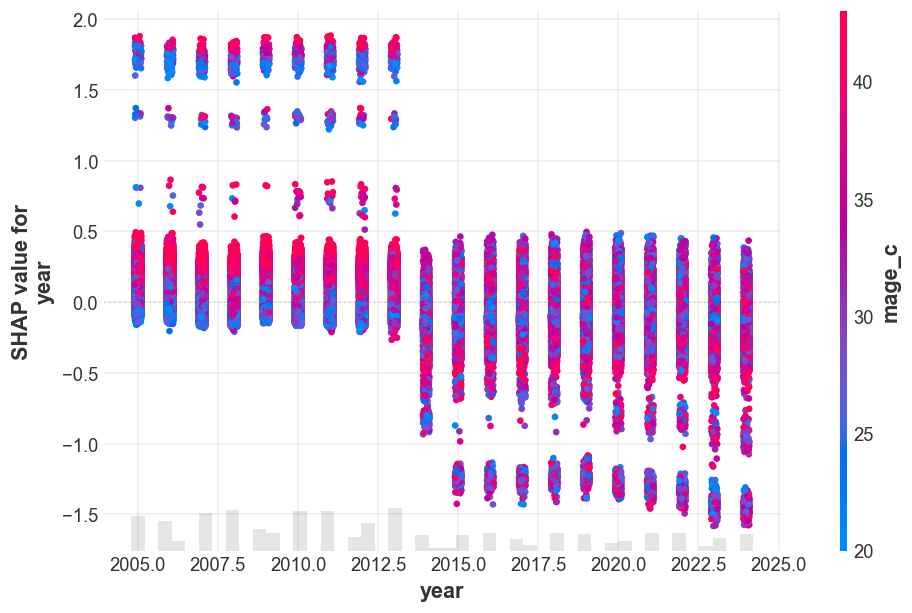

In [66]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])

Model 2

## Calibration


In [67]:
p_cal_raw = gbm.predict(X_cal, num_iteration=gbm.best_iteration, raw_score=True)

ValueError: train and valid dataset categorical_feature do not match.

In [ ]:
calibrator = LogisticRegression(solver="lbfgs", max_iter=1000)
calibrator.fit(p_cal_raw.reshape(-1, 1), y_cal)

In [ ]:
def predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=None):
    p_raw = gbm.predict(X_new, num_iteration=num_iteration, raw_score=True)
    return calibrator.predict_proba(p_raw.reshape(-1, 1))[:, 1]

## Prediction


In [ ]:
p_valid_cal = predict_proba_calibrated(
    gbm, calibrator, X_valid, num_iteration=gbm.best_iteration
)
p_valid_raw = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

print("Raw logloss:", log_loss(y_valid, p_valid_raw, labels=[0, 1]))
print("Cal logloss:", log_loss(y_valid, p_valid_cal, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid_raw))
print("Cal brier:  ", brier_score_loss(y_valid, p_valid_cal))